In [1]:
import ast
from pathlib import Path

import folium
import humanize
import pandas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


# U for Uber, T for T4c, O for OpenStreetMap
START_DAY = 21
END_DAY = 27  # incl.
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")
OBASEPATH = Path("/iarai/public/t4c/osm")

CITY = "london"
YEAR = 2019
MONTH = 10

DAYTIME_START_HOUR = 8
DAYTIME_END_HOUR = 18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
    "living_street",
    "service",
    "cycleway",
    "road",
    "construction",
]

In [3]:
plt.rcParams["axes.labelsize"] = 32
plt.rcParams['legend.title_fontsize'] = 28
plt.rcParams['legend.fontsize'] = 24

In [4]:
# simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']
simplified_filter = lambda hw: hw in [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]

In [5]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

## Load Uber segment speeds daytime and within bounding box

In [6]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f"movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet")
uspeeds_df = uspeeds_df[(uspeeds_df["day"] >= START_DAY) & (uspeeds_df["day"] <= END_DAY)]
uspeeds_df["speed_kph_mean"] = uspeeds_df["speed_mph_mean"] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

u           v      osmid  year  month  day  hour  \
8         1343922650      108500    8179128  2019     10   21    12   
10        1343922650      108500    8179128  2019     10   24    18   
14        1343922650      108500    8179128  2019     10   27    20   
19        1343922650      108500    8179128  2019     10   25    15   
23        1343922650      108500    8179128  2019     10   21     9   
...              ...         ...        ...   ...    ...  ...   ...   
47121766  4804443645  3863127062  688989358  2019     10   26     9   
47121774  4804443645  3863127062  688989358  2019     10   24    20   
47121781  4804443645  3863127062  688989358  2019     10   24     8   
47121785  4804443645  3863127062  688989358  2019     10   21    19   
47121789  4804443645  3863127062  688989358  2019     10   23     7   

          speed_mph_mean  speed_mph_stddev  speed_kph_mean  \
8                 11.078             1.550       17.828269   
10                11.507             6.372       18.518675   
14                 9.204             3.180       14.812365   
19                10.188             3.018       16.395956   
23                 9.261             4.482       14.904098   
...                  ...               ...             ...   
47121766          18.519             6.165       29.803367   
47121774          15.994             2.497       25.739784   
47121781          15.435             2.578       24.840163   
47121785          14.349             4.693       23.092420   
47121789          17.052             4.195       27.442466   

                                     gkey  
8               1343922650_108500_8179128  
10              1343922650_108500_8179128  
14              1343922650_108500_8179128  
19              1343922650_108500_8179128  
23              1343922650_108500_8179128  
...                                   ...  
47121766  4804443645_3863127062_688989358  
47121774  4804443645_3863127062_688989358  
47121781  4804443645_3863127062_688989358  
47121785  4804443645_3863127062_688989358  
47121789  4804443645_3863127062_688989358  

[10635026 rows x 11 columns]

## Load our segment speeds and aggregate by hour

In [7]:
tspeeds_l = []
for i in range(START_DAY, END_DAY + 1):
    f = TBASEPATH / "speed_classes" / CITY / f"speed_classes_{YEAR}-{MONTH}-{i}.parquet"
    print(f)
    df = pd.read_parquet(f)
    # ['u', 'v', 'gkey', 'osmid', 'day', 't', 'volume_class', 'volume','median_speed_kph', 'mean_speed_kph', 'std_speed_kph', 'free_flow_kph'],
    #     print(df.columns)
    df["date"] = df["day"]
    df["year"] = YEAR
    df["month"] = MONTH
    df["day"] = i
    df["hour"] = df["t"] // 4
    df = (
        df[["u", "v", "gkey", "year", "month", "day", "hour", "volume", "volume_class", "median_speed_kph", "free_flow_kph", "std_speed_kph"]]
        .groupby(by=["u", "v", "gkey", "year", "month", "day", "hour"])
        .agg(
            volume_class=("volume_class", "mean"),
            volume=("volume", "mean"),
            std_speed_kph=("std_speed_kph", "mean"),
            median_speed_kph=("median_speed_kph", "mean"),
            free_flow_kph=("free_flow_kph", "first"),
        )
        .reset_index()
    )
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
# tspeeds_df = tspeeds_df.rename(columns={'osmid': 'osm_way_id'})
tspeeds_df

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-21.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-22.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-23.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-24.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-25.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-26.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-27.parquet


u           v                             gkey  year  month  \
0             78112    25508583         78112_25508583_129375498  2019     10   
1             78112    25508583         78112_25508583_129375498  2019     10   
2             78112    25508583         78112_25508583_129375498  2019     10   
3             78112    25508583         78112_25508583_129375498  2019     10   
4             78112    25508583         78112_25508583_129375498  2019     10   
...             ...         ...                              ...   ...    ...   
1380556  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380557  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380558  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380559  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380560  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   

         day  hour  volume_class  volume  std_speed_kph  median_speed_kph  \
0         21     7      3.000000     3.0      19.411765         19.411765   
1         21     8      4.000000    11.5       2.376391         44.588235   
2         21     9      2.000000     2.5       2.608359         45.176471   
3         21    10      4.333333     6.0      12.524114         42.823529   
4         21    11      4.000000     6.5       7.879914         26.705882   
...      ...   ...           ...     ...            ...               ...   
1380556   27    16      1.000000     2.0       1.882353         52.705882   
1380557   27    18      3.000000     3.0       0.470588         37.176471   
1380558   27    20      1.000000     2.0       0.470588         42.352941   
1380559   27    22      1.000000     2.0       2.117647         56.705882   
1380560   27    23      1.000000     1.5       0.235294         50.117647   

         free_flow_kph  
0            45.176471  
1            45.176471  
2            45.176471  
3            45.176471  
4            45.176471  
...                ...  
1380556      47.294118  
1380557      47.294118  
1380558      47.294118  
1380559      47.294118  
1380560      47.294118  

[12004258 rows x 12 columns]

In [8]:
u_ids = set(zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["gkey"]))
u_ids

{(140407216, 334378479, '140407216_334378479_76701899'),
 (30132403, 30132328, '30132403_30132328_4728615'),
 (3748518410, 256626690, '3748518410_256626690_371270457'),
 (102949834, 102949936, '102949834_102949936_11546161'),
 (1646872722, 1740178886, '1646872722_1740178886_162072192'),
 (195634, 242954, '195634_242954_4303088'),
 (5111933471, 432919, '5111933471_432919_525476994'),
 (5224240255, 878467859, '5224240255_878467859_4242480'),
 (3889758730, 3889758756, '3889758730_3889758756_517617156'),
 (598310279, 1502700648, '598310279_1502700648_46848860'),
 (25378110, 25536889, '25378110_25536889_4259905'),
 (4089002897, 1674932589, '4089002897_1674932589_584240938'),
 (3079159738, 25582774, '3079159738_25582774_4263364'),
 (25302965, 29874869, '25302965_29874869_224244587'),
 (1667715468, 1667715417, '1667715468_1667715417_551981502'),
 (43724616, 43723284, '43724616_43723284_387386689'),
 (25322642, 800507920, '25322642_800507920_4240513'),
 (5046627645, 1215563891, '5046627645_121

In [9]:
t_ids = set(zip(tspeeds_df["u"], tspeeds_df["v"], tspeeds_df["gkey"]))
t_ids

{(21558014, 6315366527, '21558014_6315366527_24670946'),
 (25580368, 25580369, '25580368_25580369_633769691'),
 (140407216, 334378479, '140407216_334378479_76701899'),
 (130239088, 130239086, '130239088_130239086_11158128'),
 (206343974, 206343929, '206343974_206343929_11644476'),
 (1997178759, 1997178727, '1997178759_1997178727_10054229'),
 (2813579019, 81604190, '2813579019_81604190_276778184'),
 (4395058250, 4395059830, '4395058250_4395059830_441808910'),
 (18393176, 26756596, '18393176_26756596_4020012'),
 (102949834, 102949936, '102949834_102949936_11546161'),
 (1898643494, 1410095736, '1898643494_1410095736_272168399'),
 (195634, 242954, '195634_242954_4303088'),
 (5111933471, 432919, '5111933471_432919_525476994'),
 (5224240255, 878467859, '5224240255_878467859_4242480'),
 (3889758730, 3889758756, '3889758730_3889758756_517617156'),
 (25378110, 25536889, '25378110_25536889_4259905'),
 (25302965, 29874869, '25302965_29874869_224244587'),
 (43724616, 43723284, '43724616_43723284_3

In [10]:
# does not hold with the restricted time frame...
# assert t_ids.issubset(u_ids)

## Restrict to daytime only

In [11]:
tspeeds_df = tspeeds_df[(tspeeds_df["hour"] >= DAYTIME_START_HOUR) & (tspeeds_df["hour"] < DAYTIME_END_HOUR)]
tspeeds_df

u           v                             gkey  year  month  \
1             78112    25508583         78112_25508583_129375498  2019     10   
2             78112    25508583         78112_25508583_129375498  2019     10   
3             78112    25508583         78112_25508583_129375498  2019     10   
4             78112    25508583         78112_25508583_129375498  2019     10   
5             78112    25508583         78112_25508583_129375498  2019     10   
...             ...         ...                              ...   ...    ...   
1380552  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380553  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380554  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380555  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   
1380556  6577745911  5930672687  6577745911_5930672687_646234311  2019     10   

         day  hour  volume_class  volume  std_speed_kph  median_speed_kph  \
1         21     8      4.000000    11.5       2.376391         44.588235   
2         21     9      2.000000     2.5       2.608359         45.176471   
3         21    10      4.333333     6.0      12.524114         42.823529   
4         21    11      4.000000     6.5       7.879914         26.705882   
5         21    12      1.000000     2.0      16.000000         36.705882   
...      ...   ...           ...     ...            ...               ...   
1380552   27    12      1.000000     2.0       0.000000         53.647059   
1380553   27    13      2.000000     2.5       2.294118         45.000000   
1380554   27    14      3.666667     5.0       1.058824         45.607843   
1380555   27    15      1.000000     2.0       0.000000         46.588235   
1380556   27    16      1.000000     2.0       1.882353         52.705882   

         free_flow_kph  
1            45.176471  
2            45.176471  
3            45.176471  
4            45.176471  
5            45.176471  
...                ...  
1380552      47.294118  
1380553      47.294118  
1380554      47.294118  
1380555      47.294118  
1380556      47.294118  

[6631168 rows x 12 columns]

In [12]:
uspeeds_df = uspeeds_df[(uspeeds_df["hour"] >= DAYTIME_START_HOUR) & (uspeeds_df["hour"] < DAYTIME_END_HOUR)]
uspeeds_df

u           v      osmid  year  month  day  hour  \
8         1343922650      108500    8179128  2019     10   21    12   
19        1343922650      108500    8179128  2019     10   25    15   
23        1343922650      108500    8179128  2019     10   21     9   
32        1343922650      108500    8179128  2019     10   27    11   
38        1343922650      108500    8179128  2019     10   25    16   
...              ...         ...        ...   ...    ...  ...   ...   
47121757  4804443645  3863127062  688989358  2019     10   24     9   
47121763  4804443645  3863127062  688989358  2019     10   21    10   
47121764  4804443645  3863127062  688989358  2019     10   21    16   
47121766  4804443645  3863127062  688989358  2019     10   26     9   
47121781  4804443645  3863127062  688989358  2019     10   24     8   

          speed_mph_mean  speed_mph_stddev  speed_kph_mean  \
8                 11.078             1.550       17.828269   
19                10.188             3.018       16.395956   
23                 9.261             4.482       14.904098   
32                 9.877             2.190       15.895451   
38                10.145             3.661       16.326754   
...                  ...               ...             ...   
47121757          15.198             4.081       24.458749   
47121763          17.880             5.863       28.774999   
47121764          16.509             4.731       26.568594   
47121766          18.519             6.165       29.803367   
47121781          15.435             2.578       24.840163   

                                     gkey  
8               1343922650_108500_8179128  
19              1343922650_108500_8179128  
23              1343922650_108500_8179128  
32              1343922650_108500_8179128  
38              1343922650_108500_8179128  
...                                   ...  
47121757  4804443645_3863127062_688989358  
47121763  4804443645_3863127062_688989358  
47121764  4804443645_3863127062_688989358  
47121766  4804443645_3863127062_688989358  
47121781  4804443645_3863127062_688989358  

[4667415 rows x 11 columns]

## Merge with road graph in bounding box

In [13]:
df_edges = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")
df_edges

gkey           u           v      osmid  \
0              78112_25508583_129375498       78112    25508583  129375498   
1              78112_25508584_129375498       78112    25508584  129375498   
2            99936_2146383887_204647020       99936  2146383887  204647020   
3            99936_4544836433_233623258       99936  4544836433  233623258   
4                  99937_200047_4257261       99937      200047    4257261   
...                                 ...         ...         ...        ...   
234303   6577730921_254761207_358627524  6577730921   254761207  358627524   
234304    6577730921_6577730928_8227762  6577730921  6577730928    8227762   
234305     6577730928_2379175_700435511  6577730928     2379175  700435511   
234306    6577745911_36728211_646234311  6577745911    36728211  646234311   
234307  6577745911_5930672687_646234311  6577745911  5930672687  646234311   

        speed_kph maxspeed       highway oneway lanes tunnel  length_meters  \
0            40.4           unclassified                          19.407060   
1            40.4           unclassified                          63.857249   
2            48.3   30 mph  unclassified                          12.645031   
3            48.3   30 mph  unclassified                          47.220818   
4            48.3   30 mph  unclassified                          59.033945   
...           ...      ...           ...    ...   ...    ...            ...   
234303       46.2               tertiary                         134.082828   
234304       36.3            residential                          51.325126   
234305       36.3            residential                          57.576832   
234306       48.3   30 mph       primary                         305.243521   
234307       48.3   30 mph       primary                          90.750571   

                                                 geometry            name  
0       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...    Outer Circle  
1       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...    Outer Circle  
2       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x94o\x1...       York Gate  
3       b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x94o\x1...       York Gate  
4       b'\x01\x02\x00\x00\x00\x07\x00\x00\x005\x9a\\\...       York Gate  
...                                                   ...             ...  
234303  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdfw\xc...   Golborne Road  
234304  b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xdfw\xc...  Bevington Road  
234305  b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x96\x7f...  Bevington Road  
234306  b'\x01\x02\x00\x00\x00\x07\x00\x00\x00\x82\xdb...     Coombe Lane  
234307  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x82\xdb...     Coombe Lane  

[234308 rows x 13 columns]

In [14]:
df_nodes = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
df_nodes

node_id         x          y  \
0            78112 -0.145792  51.526976   
1            99936 -0.152791  51.523611   
2            99937 -0.152024  51.523018   
3            99940 -0.155763  51.523085   
4           101818 -0.148104  51.535179   
...            ...       ...        ...   
140407  6577710674 -0.225660  51.505155   
140408  6577710675 -0.227720  51.502322   
140409  6577730921 -0.209469  51.521176   
140410  6577730928 -0.209009  51.521139   
140411  6577745911 -0.239748  51.411286   

                                                 geometry  
0       b'\x01\x01\x00\x00\x00R\xaf\x00KS\xa9\xc2\xbfq...  
1       b'\x01\x01\x00\x00\x00\x94o\x11s\xa4\x8e\xc3\x...  
2       b'\x01\x01\x00\x00\x005\x9a\\\x8c\x81u\xc3\xbf...  
3       b'\x01\x01\x00\x00\x00va\xb5C\r\xf0\xc3\xbf\x0...  
4       b'\x01\x01\x00\x00\x00\xd4\xe7\xb4\xb8\x10\xf5...  
...                                                   ...  
140407  b"\x01\x01\x00\x00\x00'\x8c\xc1\x1en\xe2\xcc\x...  
140408  b'\x01\x01\x00\x00\x00K\x93R\xd0\xed%\xcd\xbf,...  
140409  b'\x01\x01\x00\x00\x00\xdfw\xc2\x01\xe3\xcf\xc...  
140410  b'\x01\x01\x00\x00\x00\x96\x7f\x88h\xcf\xc0\xc...  
140411  b'\x01\x01\x00\x00\x00\x82\xdb$P\x0e\xb0\xce\x...  

[140412 rows x 4 columns]

In [15]:
df_edges = df_edges.merge(df_nodes, left_on="u", right_on="node_id", suffixes=["", "_u"]).merge(df_nodes, left_on="v", right_on="node_id", suffixes=["", "_v"])
df_edges.rename(columns={"x": "x_u", "y": "y_u"}, inplace=True)
del df_edges["geometry_u"]
del df_edges["geometry_v"]
df_edges

gkey           u           v      osmid  \
0              78112_25508583_129375498       78112    25508583  129375498   
1             103928_25508583_129375498      103928    25508583  129375498   
2              78112_25508584_129375498       78112    25508584  129375498   
3         1427449243_25508584_129375498  1427449243    25508584  129375498   
4            99936_2146383887_204647020       99936  2146383887  204647020   
...                                 ...         ...         ...        ...   
234303  6575658505_6575658506_700232903  6575658505  6575658506  700232903   
234304    6575658506_25502538_700232901  6575658506    25502538  700232901   
234305  6577417598_1371834796_700403310  6577417598  1371834796  700403310   
234306  6577710674_6577710672_700436498  6577710674  6577710672  700436498   
234307   6577710675_425362646_700436497  6577710675   425362646  700436497   

        speed_kph maxspeed       highway oneway lanes tunnel  length_meters  \
0            40.4           unclassified                          19.407060   
1            40.4           unclassified                          77.305720   
2            40.4           unclassified                          63.857249   
3            40.4           unclassified                           7.084361   
4            48.3   30 mph  unclassified                          12.645031   
...           ...      ...           ...    ...   ...    ...            ...   
234303       36.3            residential                         224.839319   
234304       36.3            residential                          12.653903   
234305       64.4   40 mph         trunk                         303.380347   
234306       32.2   20 mph   residential                         256.990588   
234307       32.2   20 mph   residential                          21.618059   

                                                 geometry             name  \
0       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...     Outer Circle   
1       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00A\x80\x0...     Outer Circle   
2       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...     Outer Circle   
3       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x80\xf6...     Outer Circle   
4       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x94o\x1...        York Gate   
...                                                   ...              ...   
234303  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xa6\x02...  Phillimore Walk   
234304  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xf1_\xc...  Phillimore Walk   
234305  b'\x01\x02\x00\x00\x00\x04\x00\x00\x00z_K~z"\x...    Brighton Road   
234306  b"\x01\x02\x00\x00\x00\x07\x00\x00\x00'\x8c\xc...     Pennard Road   
234307  b'\x01\x02\x00\x00\x00\x03\x00\x00\x00K\x93R\x...       Lime Grove   

           node_id       x_u        y_u   node_id_v       x_v        y_v  
0            78112 -0.145792  51.526976    25508583 -0.145783  51.526802  
1           103928 -0.145759  51.526107    25508583 -0.145783  51.526802  
2            78112 -0.145792  51.526976    25508584 -0.145807  51.527550  
3       1427449243 -0.145808  51.527614    25508584 -0.145807  51.527550  
4            99936 -0.152791  51.523611  2146383887 -0.152679  51.523630  
...            ...       ...        ...         ...       ...        ...  
234303  6575658505 -0.195865  51.500572  6575658506 -0.197757  51.499861  
234304  6575658506 -0.197757  51.499861    25502538 -0.197864  51.499821  
234305  6577417598 -0.211990  51.314768  1371834796 -0.211668  51.317477  
234306  6577710674 -0.225660  51.505155  6577710672 -0.224990  51.502943  
234307  6577710675 -0.227720  51.502322   425362646 -0.227731  51.502516  

[234308 rows x 19 columns]

In [16]:
def in_bb(x, y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

In [17]:
# London
y_min, y_max, x_min, x_max = 51.20500, 51.70000, -0.36900, 0.06700

In [18]:
df_edges["in_bb"] = [(in_bb(x_u, y_u) or in_bb(x_v, y_v)) for x_u, y_u, x_v, y_v in zip(df_edges["x_u"], df_edges["y_u"], df_edges["x_v"], df_edges["y_v"])]

In [19]:
df_edges = df_edges[df_edges["in_bb"] == True]

In [20]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=["u", "v", "gkey", "year", "month", "day", "hour"]).merge(df_edges, on=["u", "v", "gkey"])
ut_merged

u           v    osmid_x  year  month  day  hour  \
0        1343922650      108500    8179128  2019     10   21    12   
1        1343922650      108500    8179128  2019     10   21     9   
2        1343922650      108500    8179128  2019     10   25    16   
3        1343922650      108500    8179128  2019     10   26    17   
4        1343922650      108500    8179128  2019     10   24    11   
...             ...         ...        ...   ...    ...  ...   ...   
3096092  4804443645  3863127062  688989358  2019     10   25    10   
3096093  4804443645  3863127062  688989358  2019     10   24     9   
3096094  4804443645  3863127062  688989358  2019     10   21    10   
3096095  4804443645  3863127062  688989358  2019     10   21    16   
3096096  4804443645  3863127062  688989358  2019     10   24     8   

         speed_mph_mean  speed_mph_stddev  speed_kph_mean  ... length_meters  \
0                11.078             1.550       17.828269  ...      5.820857   
1                 9.261             4.482       14.904098  ...      5.820857   
2                10.145             3.661       16.326754  ...      5.820857   
3                10.440             3.482       16.801510  ...      5.820857   
4                12.157             5.549       19.564746  ...      5.820857   
...                 ...               ...             ...  ...           ...   
3096092          15.372             3.225       24.738774  ...    199.711486   
3096093          15.198             4.081       24.458749  ...    199.711486   
3096094          17.880             5.863       28.774999  ...    199.711486   
3096095          16.509             4.731       26.568594  ...    199.711486   
3096096          15.435             2.578       24.840163  ...    199.711486   

                                                  geometry          name  \
0        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
1        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
2        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
3        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
4        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
...                                                    ...           ...   
3096092  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3096093  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3096094  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3096095  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3096096  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   

            node_id       x_u        y_u   node_id_v       x_v        y_v  \
0        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
1        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
2        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
3        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
4        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
...             ...       ...        ...         ...       ...        ...   
3096092  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3096093  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3096094  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3096095  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3096096  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   

        in_bb  
0        True  
1        True  
2        True  
3        True  
4        True  
...       ...  
3096092  True  
3096093  True  
3096094  True  
3096095  True  
3096096  True  

[3096097 rows x 33 columns]

## Matching rate

In [21]:
uspeeds_with_road_graph = uspeeds_df.merge(df_edges, on=["u", "v", "gkey"])
uspeeds_with_road_graph

u           v    osmid_x  year  month  day  hour  \
0        1343922650      108500    8179128  2019     10   21    12   
1        1343922650      108500    8179128  2019     10   25    15   
2        1343922650      108500    8179128  2019     10   21     9   
3        1343922650      108500    8179128  2019     10   27    11   
4        1343922650      108500    8179128  2019     10   25    16   
...             ...         ...        ...   ...    ...  ...   ...   
3590904  4804443645  3863127062  688989358  2019     10   24     9   
3590905  4804443645  3863127062  688989358  2019     10   21    10   
3590906  4804443645  3863127062  688989358  2019     10   21    16   
3590907  4804443645  3863127062  688989358  2019     10   26     9   
3590908  4804443645  3863127062  688989358  2019     10   24     8   

         speed_mph_mean  speed_mph_stddev  speed_kph_mean  ... length_meters  \
0                11.078             1.550       17.828269  ...      5.820857   
1                10.188             3.018       16.395956  ...      5.820857   
2                 9.261             4.482       14.904098  ...      5.820857   
3                 9.877             2.190       15.895451  ...      5.820857   
4                10.145             3.661       16.326754  ...      5.820857   
...                 ...               ...             ...  ...           ...   
3590904          15.198             4.081       24.458749  ...    199.711486   
3590905          17.880             5.863       28.774999  ...    199.711486   
3590906          16.509             4.731       26.568594  ...    199.711486   
3590907          18.519             6.165       29.803367  ...    199.711486   
3590908          15.435             2.578       24.840163  ...    199.711486   

                                                  geometry          name  \
0        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
1        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
2        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
3        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
4        b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...  Wynford Road   
...                                                    ...           ...   
3590904  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3590905  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3590906  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3590907  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   
3590908  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...    Grove Road   

            node_id       x_u        y_u   node_id_v       x_v        y_v  \
0        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
1        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
2        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
3        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
4        1343922650 -0.115013  51.534101      108500 -0.114964  51.534082   
...             ...       ...        ...         ...       ...        ...   
3590904  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3590905  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3590906  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3590907  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   
3590908  4804443645 -0.042435  51.535028  3863127062 -0.041668  51.533404   

        in_bb  
0        True  
1        True  
2        True  
3        True  
4        True  
...       ...  
3590904  True  
3590905  True  
3590906  True  
3590907  True  
3590908  True  

[3590909 rows x 28 columns]

In [22]:
humanize.metric(len(ut_merged))

'3.10 M'

In [23]:
len(ut_merged) / len(tspeeds_df)

0.46690070286260277

In [24]:
humanize.metric(len(tspeeds_df))

'6.63 M'

In [25]:
# road_graph is only within bb
len(uspeeds_with_road_graph) / len(uspeeds_df)

0.7693571280891028

In [26]:
humanize.metric(len(uspeeds_df))

'4.67 M'

In [27]:
len(ut_merged) / len(uspeeds_with_road_graph[uspeeds_with_road_graph["in_bb"] == True])

0.8622042496760569

In [28]:
len(tspeeds_df)

6631168

In [29]:
len(uspeeds_with_road_graph)

3590909

### Speed Differences

In [30]:
ut_merged.columns

Index(['u', 'v', 'osmid_x', 'year', 'month', 'day', 'hour', 'speed_mph_mean',
       'speed_mph_stddev', 'speed_kph_mean', 'gkey', 'volume_class', 'volume',
       'std_speed_kph', 'median_speed_kph', 'free_flow_kph', 'osmid_y',
       'speed_kph', 'maxspeed', 'highway', 'oneway', 'lanes', 'tunnel',
       'length_meters', 'geometry', 'name', 'node_id', 'x_u', 'y_u',
       'node_id_v', 'x_v', 'y_v', 'in_bb'],
      dtype='object')

In [31]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"] - ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")
ut_merged

u           v    osmid_x  year  month  day  hour  \
273053       195967    28353493    4546846  2019     10   22    16   
689172       195870  1989907965   48539074  2019     10   23    13   
689173       195870  1989907965   48539074  2019     10   26     8   
689174       195870  1989907965   48539074  2019     10   22    17   
689175       195870  1989907965   48539074  2019     10   21    14   
...             ...         ...        ...   ...    ...  ...   ...   
1254779    25503723    25503725  372384749  2019     10   22    12   
1254778    25503723    25503725  372384749  2019     10   21     8   
1254777    25503723    25503725  372384749  2019     10   25    13   
1254776    25503723    25503725  372384749  2019     10   24     8   
2798652  4346458075  4376910559  436772431  2019     10   27    16   

         speed_mph_mean  speed_mph_stddev  speed_kph_mean  ...           name  \
273053           51.613             7.795       83.062865  ...                  
689172           68.856             7.538      110.812715  ...                  
689173           69.925             4.986      112.533099  ...                  
689174           55.193            14.658       88.824303  ...                  
689175           62.517             4.727      100.611109  ...                  
...                 ...               ...             ...  ...            ...   
1254779           3.972             4.347        6.392298  ...  Catton Street   
1254778           9.572             6.396       15.404602  ...  Catton Street   
1254777           3.681             2.951        5.923981  ...  Catton Street   
1254776           3.403             2.103        5.476584  ...  Catton Street   
2798652          10.284             2.148       16.550453  ...                  

            node_id       x_u        y_u   node_id_v       x_v        y_v  \
273053       195967 -0.058993  51.682574    28353493 -0.043096  51.682870   
689172       195870 -0.177291  51.684415  1989907965 -0.169578  51.687224   
689173       195870 -0.177291  51.684415  1989907965 -0.169578  51.687224   
689174       195870 -0.177291  51.684415  1989907965 -0.169578  51.687224   
689175       195870 -0.177291  51.684415  1989907965 -0.169578  51.687224   
...             ...       ...        ...         ...       ...        ...   
1254779    25503723 -0.119593  51.518231    25503725 -0.120530  51.518056   
1254778    25503723 -0.119593  51.518231    25503725 -0.120530  51.518056   
1254777    25503723 -0.119593  51.518231    25503725 -0.120530  51.518056   
1254776    25503723 -0.119593  51.518231    25503725 -0.120530  51.518056   
2798652  4346458075 -0.081328  51.630826  4376910559 -0.081751  51.630805   

         in_bb speed_diff sort_key  
273053    True  -1.023650        0  
689172    True -13.655852        0  
689173    True  -3.238982        0  
689174    True -11.010577        0  
689175    True  -6.326795        0  
...        ...        ...      ...  
1254779   True  30.078290       13  
1254778   True   2.477750       13  
1254777   True   2.546608       13  
1254776   True   1.052828       13  
2798652   True  -9.256335       15  

[3096097 rows x 35 columns]

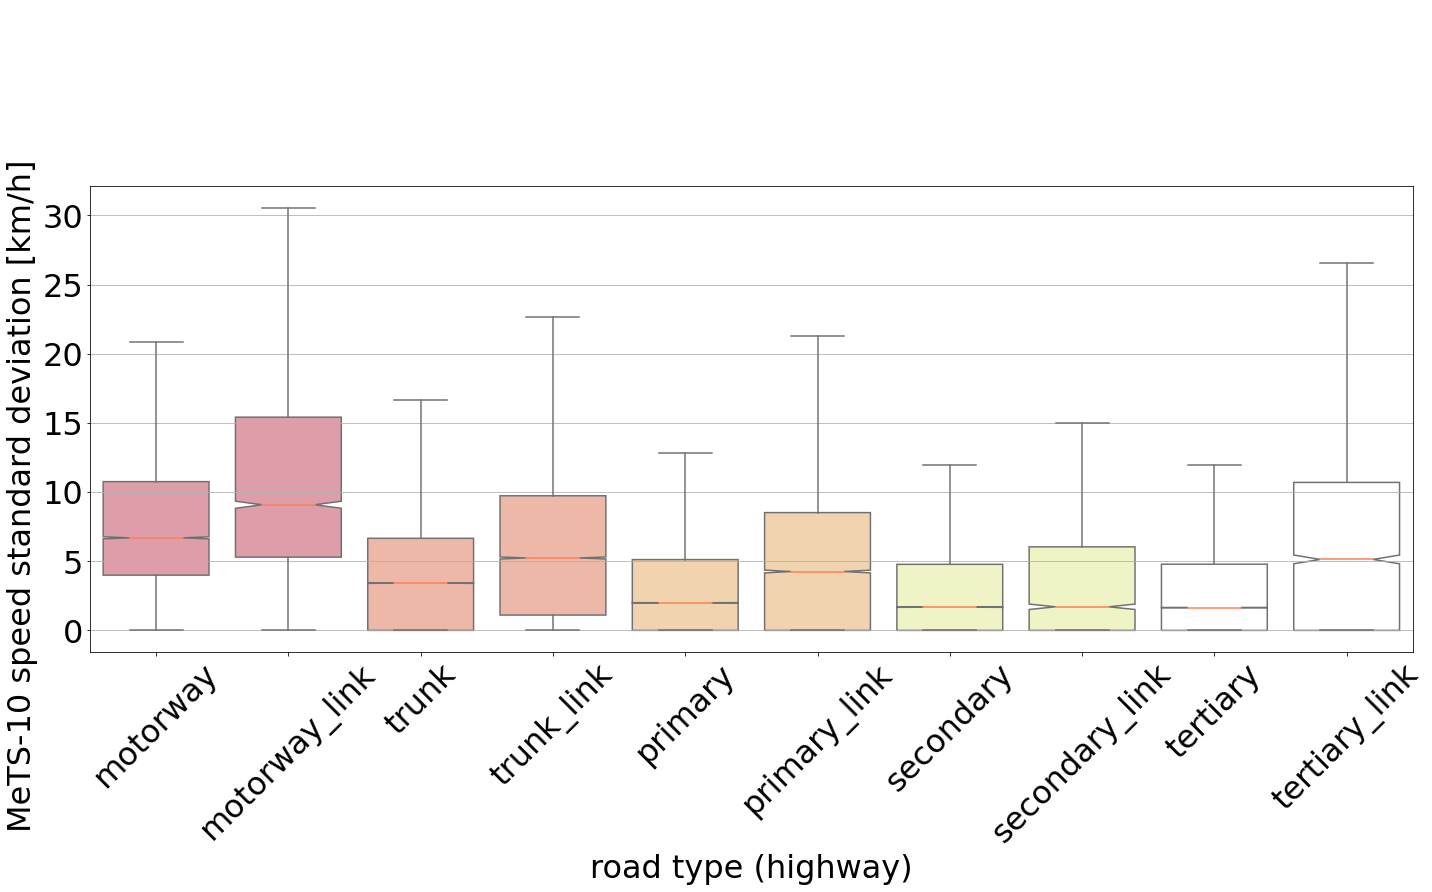

In [33]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="std_speed_kph",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='MeTS-10 speed standard deviation [km/h]               ')
#  t4c: higher stds in link classes than in the corresponding road class they link -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_std_speed_kph.pdf")

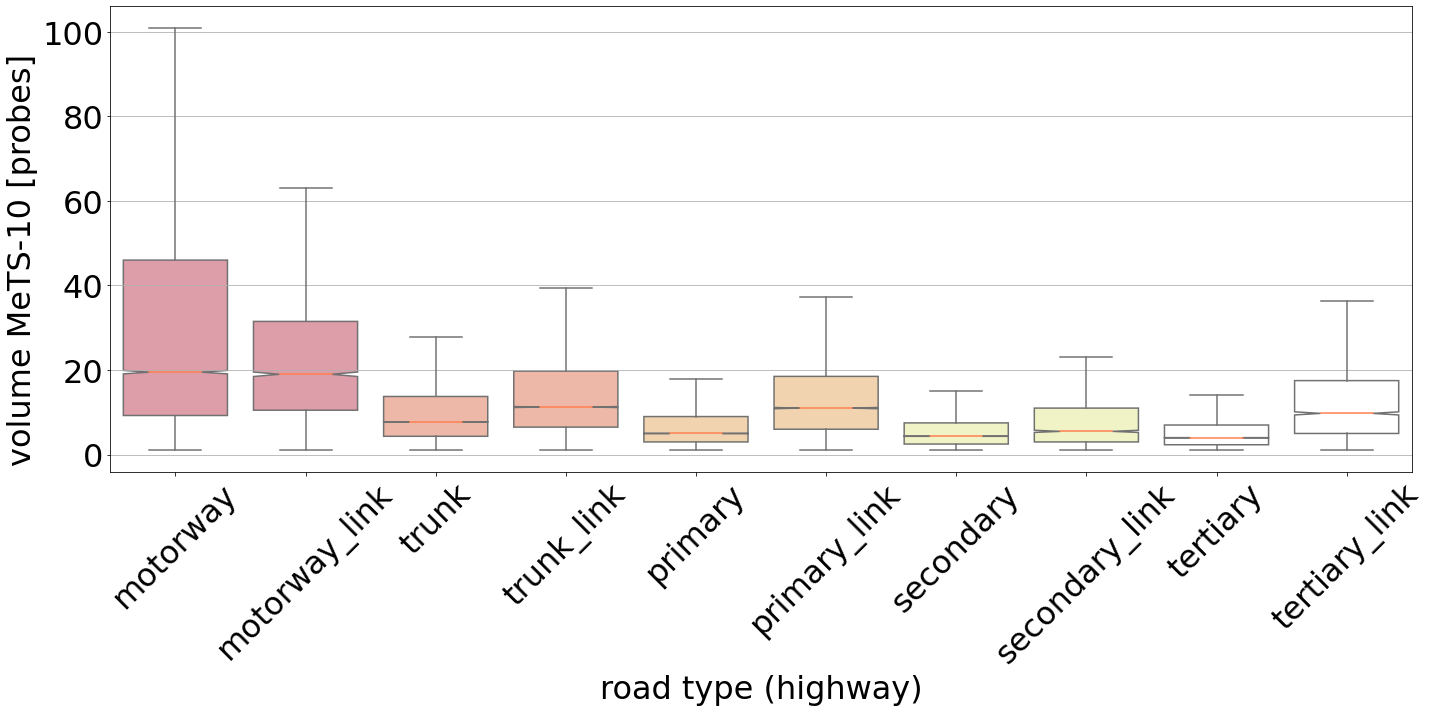

In [34]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="volume",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='volume MeTS-10 [probes]    ')
# t4c: higher volumes on links than on the class below -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_volume.pdf")

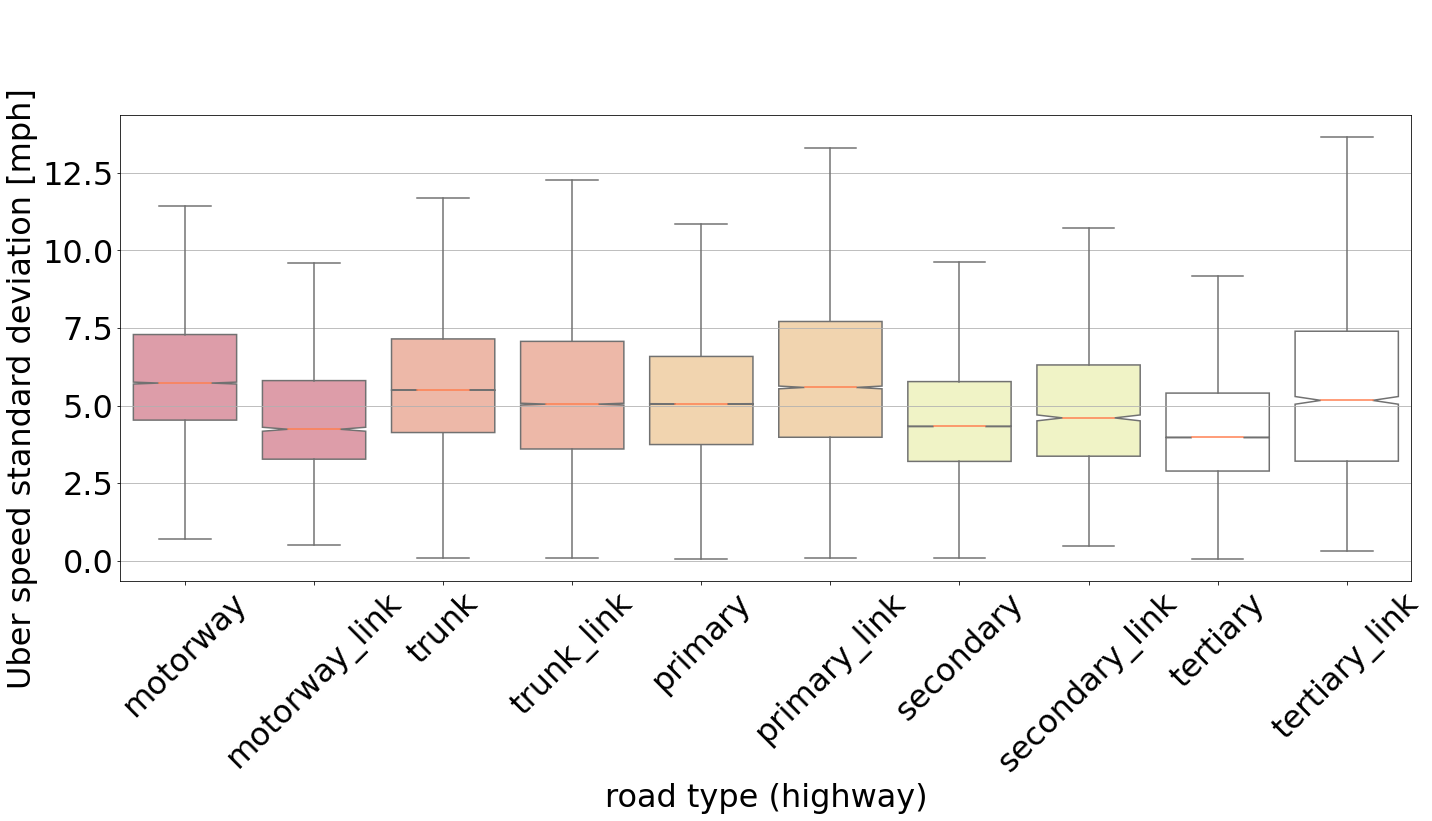

In [35]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_mph_stddev",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='Uber speed standard deviation [mph]        ')

# Uber: link class have higher std than the class they link to (apart from motorway) -> acceleration/deceleration on links plausible
plt.savefig(f"{CITY.title()}_Uber_speed_mph_stddev.pdf")

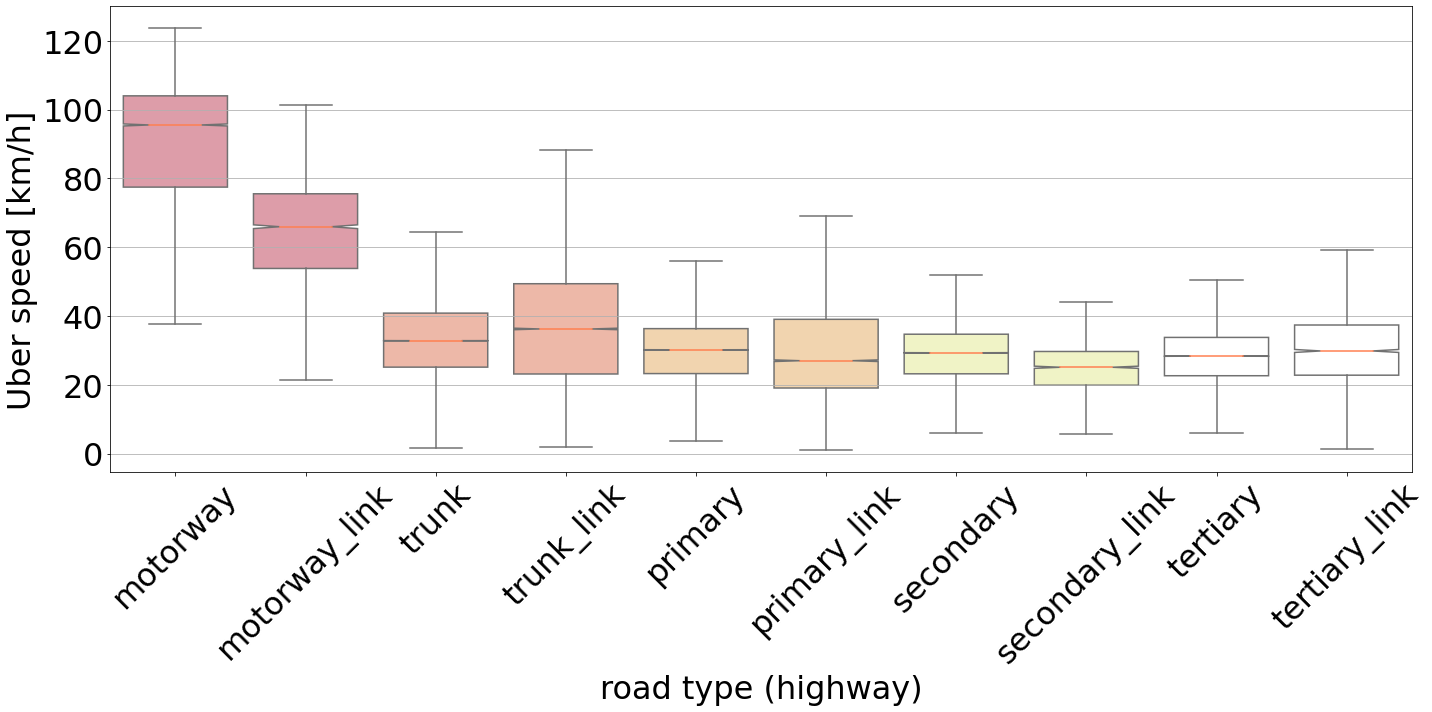

In [36]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_kph_mean",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='Uber speed [km/h]    ')
plt.savefig(f"{CITY.title()}_Uber_speed_kph_mean.pdf")

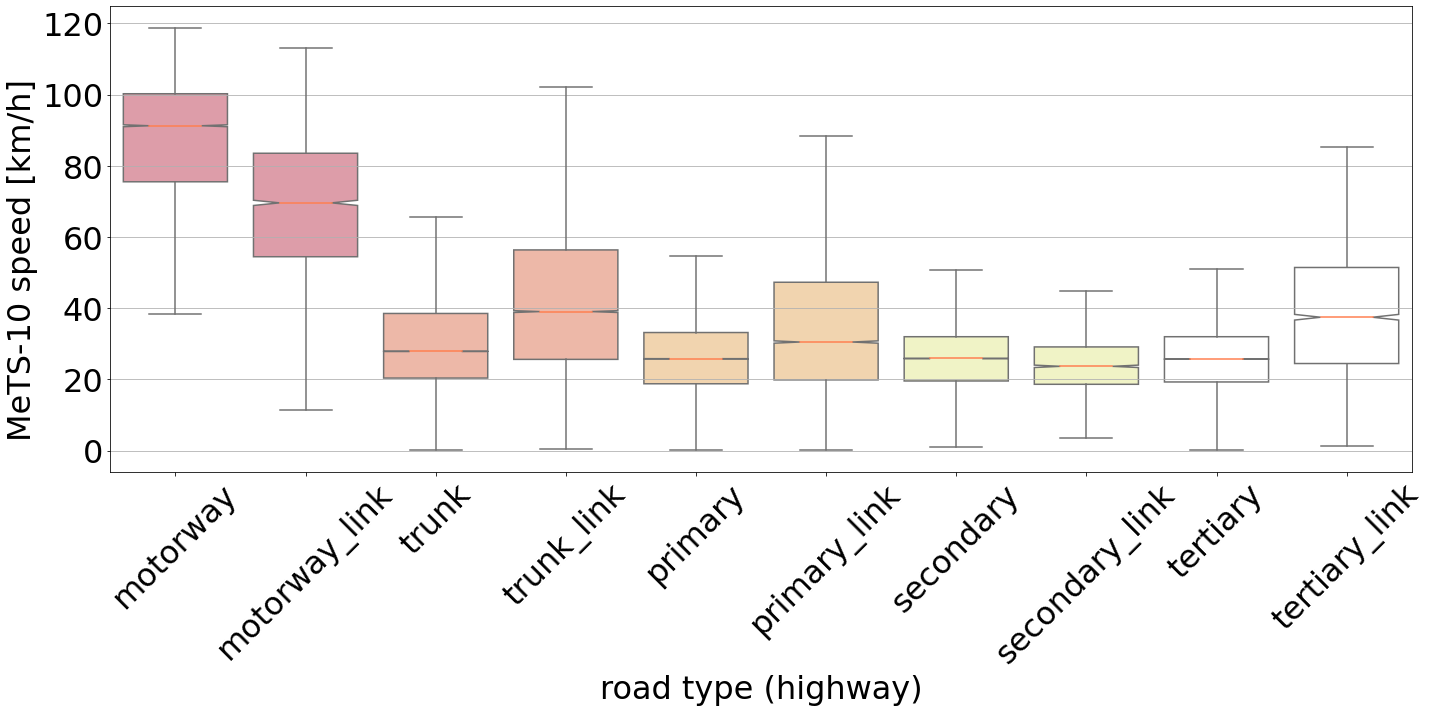

In [37]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="median_speed_kph",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='MeTS-10 speed [km/h]    ')
plt.savefig(f"{CITY.title()}_Uber_median_speed_kph.pdf")

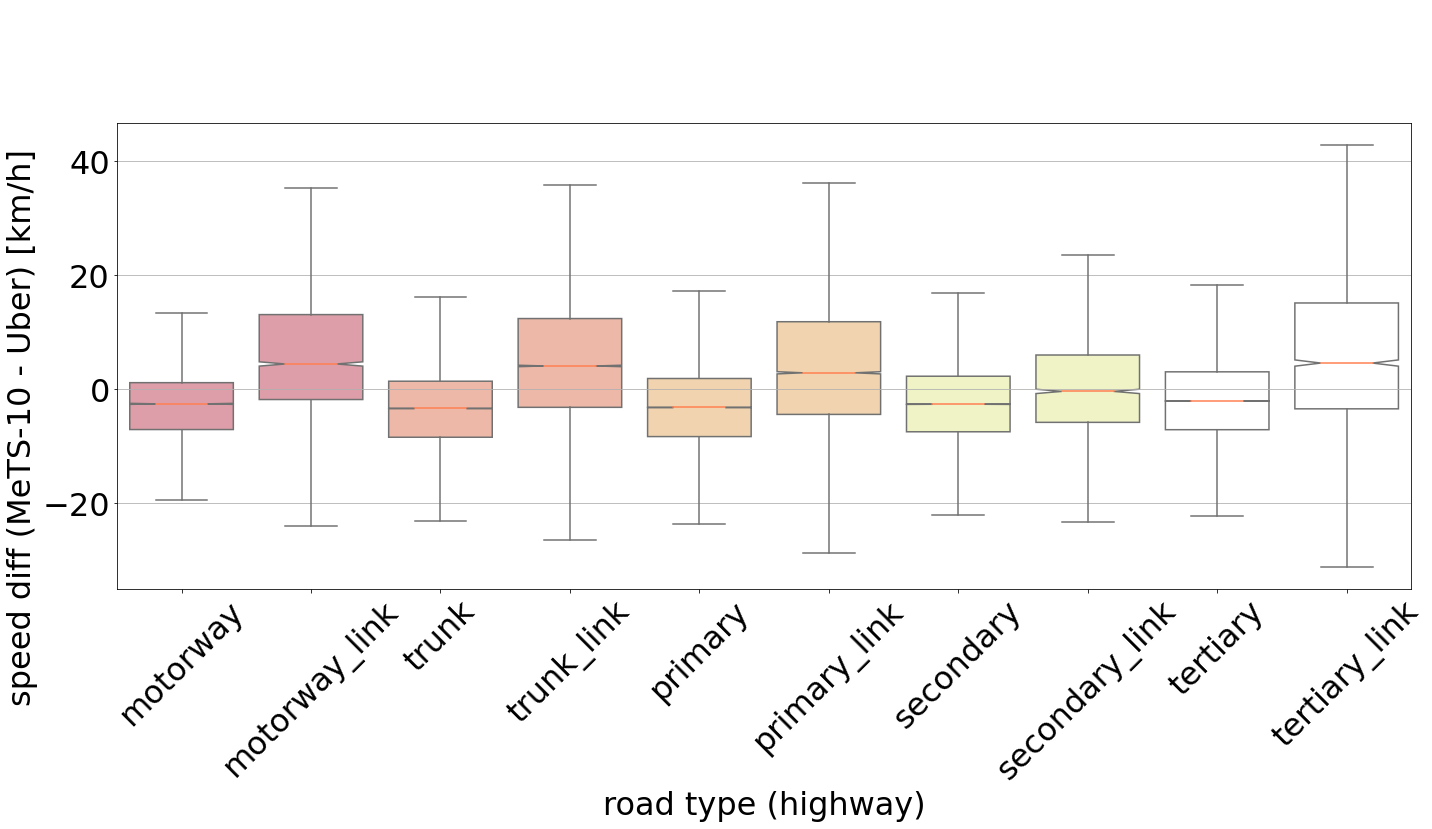

In [38]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_diff",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)

ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='speed diff (MeTS-10 - Uber) [km/h]              ')
plt.savefig(f"{CITY.title()}_Uber_speed_diff.pdf")

In [39]:
df_edges[df_edges["u"] == 3240063179]

gkey           u           v    osmid  \
220959  3240063179_1249708436_8599345  3240063179  1249708436  8599345   

        speed_kph maxspeed  highway oneway lanes tunnel  length_meters  \
220959       32.2   20 mph  primary                           4.346146   

                                                 geometry           name  \
220959  b'\x01\x02\x00\x00\x00\x03\x00\x00\x00t\x1e_\x...  London Bridge   

           node_id       x_u        y_u   node_id_v       x_v        y_v  \
220959  3240063179 -0.088403  51.506295  1249708436 -0.088381  51.506327   

        in_bb  
220959   True

In [40]:
tspeeds_df.columns

Index(['u', 'v', 'gkey', 'year', 'month', 'day', 'hour', 'volume_class',
       'volume', 'std_speed_kph', 'median_speed_kph', 'free_flow_kph'],
      dtype='object')

In [41]:
def plot_dayline(u, v, day):
    fig, ax = plt.subplots(1, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)
    ax2 = ax.twinx()

    t_data = tspeeds_df[(tspeeds_df["u"] == u) & (tspeeds_df["v"] == v) & (tspeeds_df["day"] == day)].sort_values("hour")
    sns.lineplot(t_data, x="hour", y="median_speed_kph", ax=ax, color="orange")
    sns.lineplot(t_data, x="hour", y="volume", ax=ax, color="red")
    ax.errorbar(t_data["hour"], t_data["median_speed_kph"], yerr=t_data["std_speed_kph"], capsize=2, capthick=0.5, color="orange", linewidth=0.5, linestyle=":")

    u_data = uspeeds_df[(uspeeds_df["u"] == u) & (uspeeds_df["v"] == v) & (uspeeds_df["day"] == day)].sort_values("hour")
    sns.lineplot(u_data, x="hour", y="speed_kph_mean", ax=ax2, color="blue")
    ax.errorbar(u_data["hour"], u_data["speed_kph_mean"], yerr=u_data["speed_mph_stddev"], capsize=2, capthick=0.5, color="blue", linewidth=0.5, linestyle=":")
    rec = df_edges[(df_edges["u"] == u) & (df_edges["v"] == v)].iloc[0]
    [min([u_data["speed_kph_mean"].min(), t_data["median_speed_kph"].min()]), max([u_data["speed_kph_mean"].max(), t_data["median_speed_kph"].max()])]
    ax.set_ylim([0, 120])
    ax2.set_ylim([0, 120])
    #     print(rec)
    plt.title(f"{rec['name']}, {rec['highway']} {rec['length_meters']:.2f}m")

In [42]:
#         # 3240063179	3153656030		['King William Street', 'London Bridge']
#         ("London bridge, northbound", 3240063179, 3153656030),
#         # 2180693488	1868411754	A3	Elephant and Castle
#         ("Elephant and castle, northbound", 2180693488, 1868411754),
#         #	1178910690	197630	0		A40	['Marylebone Flyover', 'Westway']
#         ("Marylebone flyover, eastbound", 2180693488, 1868411754),
#         # 195975	28419372		M25		motorway
#         ("M25 near Waltham, eastbound", 195975, 28419372),
#         # 	208885668	257550997	M25		motorway
#         ("M25 near Potters Bar, westbound", 208885668, 257550997)

### "London bridge, northbound"

In [43]:
# u = 3240063179, v = 1249708436,

In [44]:
u = 1249708436
v = 25161387

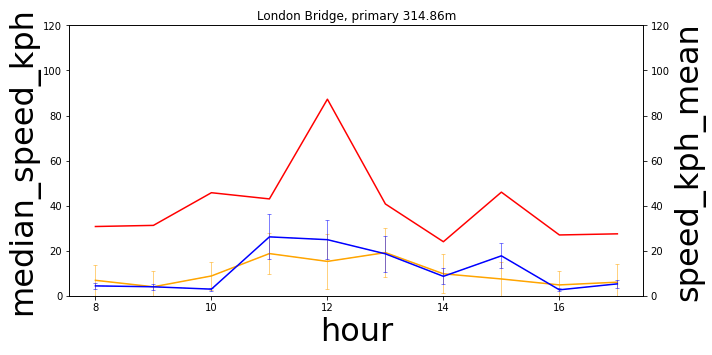

In [45]:
plot_dayline(u=u, v=v, day=21)

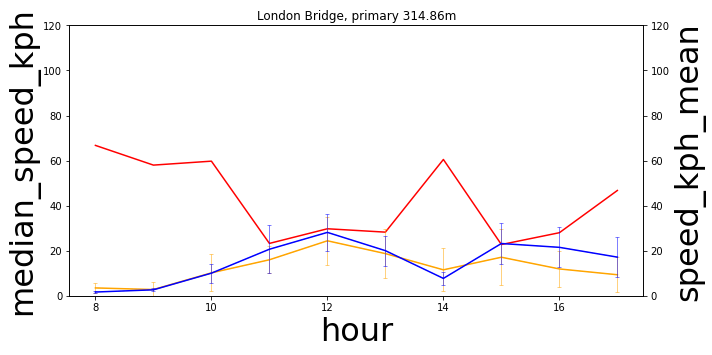

In [46]:
plot_dayline(u=u, v=v, day=22)

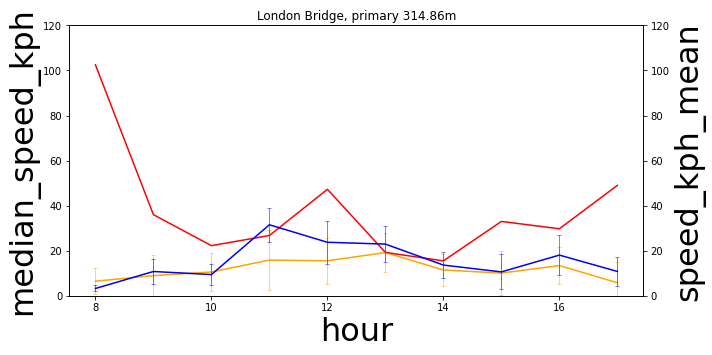

In [47]:
plot_dayline(u=u, v=v, day=23)

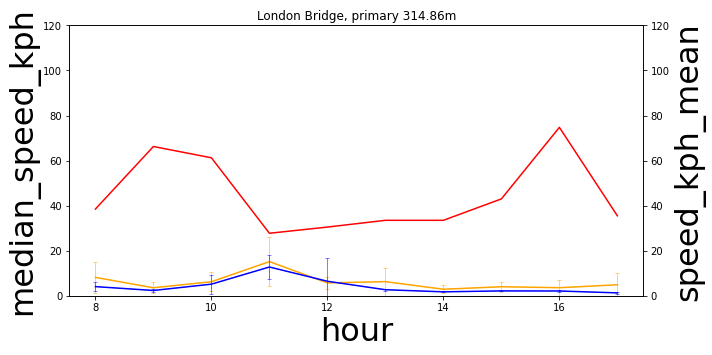

In [48]:
plot_dayline(u=u, v=v, day=24)

###         ("Marylebone flyover, eastbound", 2180693488, 1868411754),

In [49]:
u = 2180693488
v = 3890206825

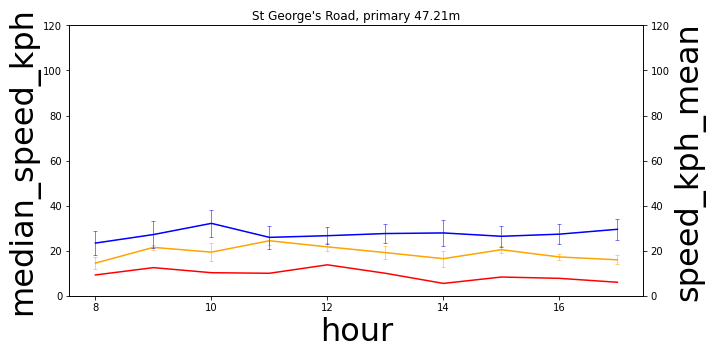

In [50]:
plot_dayline(u=u, v=v, day=21)

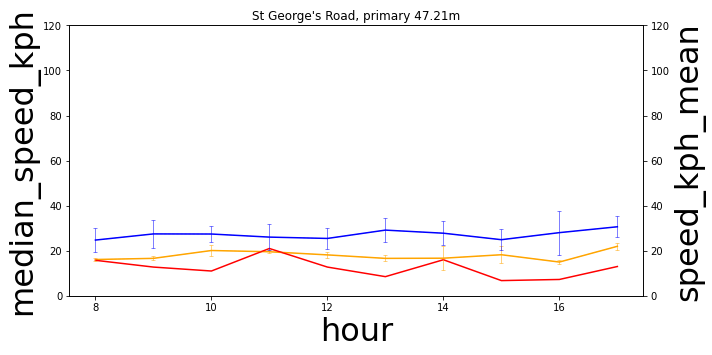

In [51]:
plot_dayline(u=u, v=v, day=22)

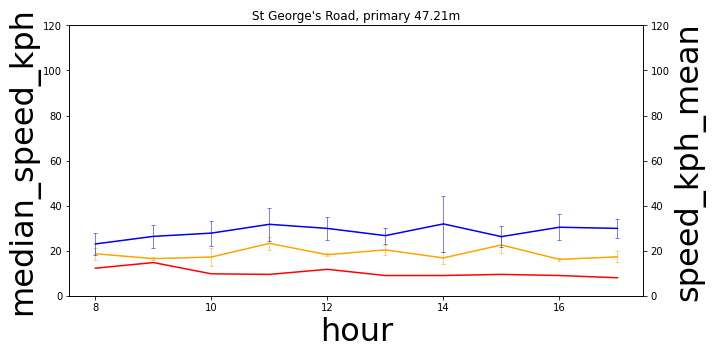

In [52]:
plot_dayline(u=u, v=v, day=23)

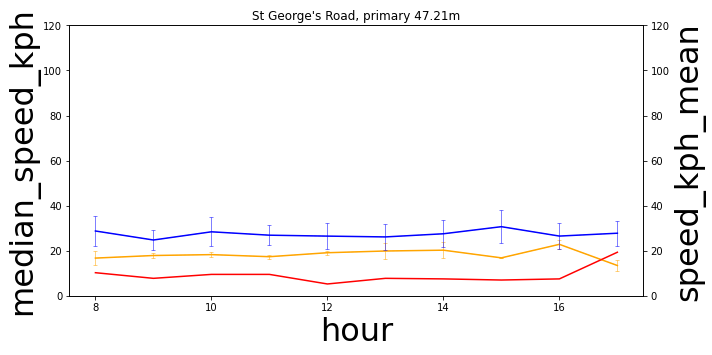

In [53]:
plot_dayline(u=u, v=v, day=24)

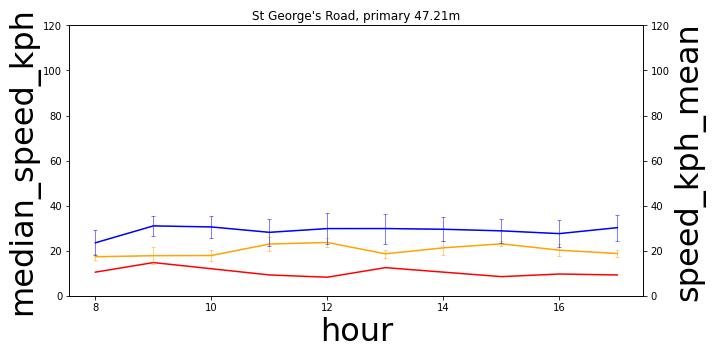

In [54]:
plot_dayline(u=u, v=v, day=25)

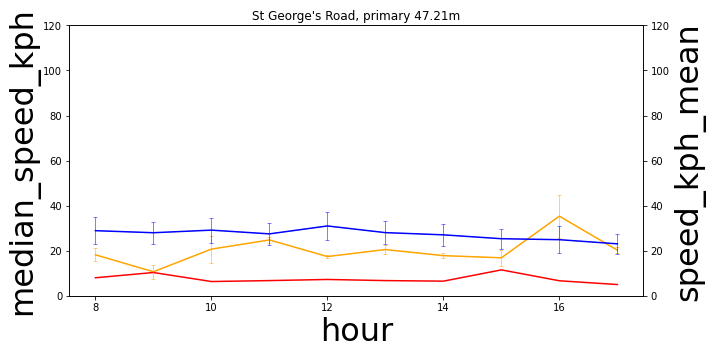

In [55]:
# Saturday
plot_dayline(u=u, v=v, day=26)

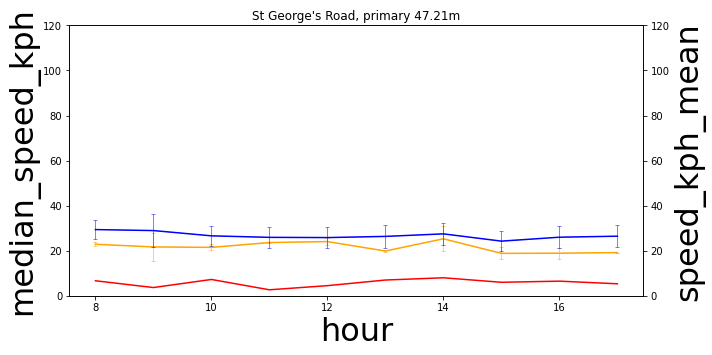

In [56]:
plot_dayline(u=u, v=v, day=27)

### ("M25 near Waltham, eastbound", 195975, 28419372),

In [57]:
u = 195975
v = 195965

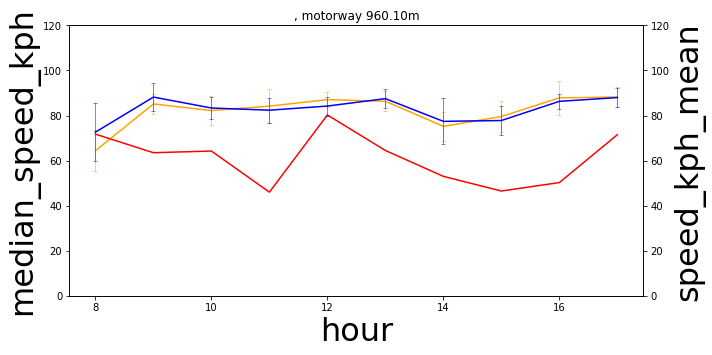

In [58]:
plot_dayline(u=u, v=v, day=21)

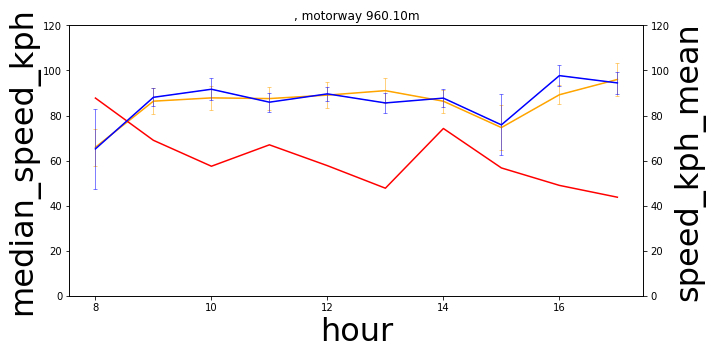

In [59]:
plot_dayline(u=u, v=v, day=22)

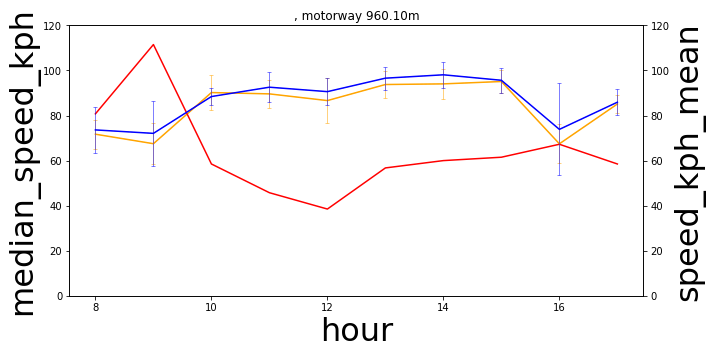

In [60]:
plot_dayline(u=u, v=v, day=23)

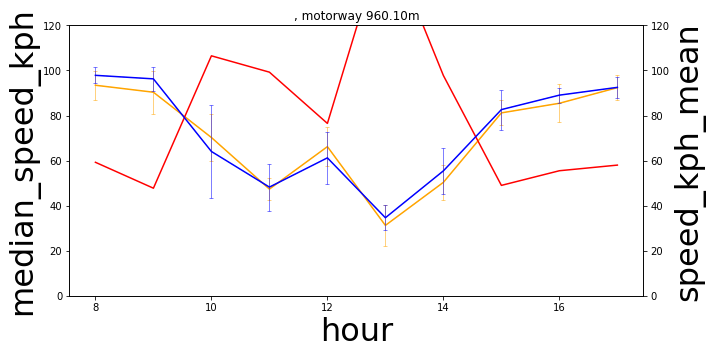

In [61]:
plot_dayline(u=u, v=v, day=24)

###  ("M25 near Potters Bar, westbound", 208885668, 257550997)

In [62]:
u = 208885668
v = 195875

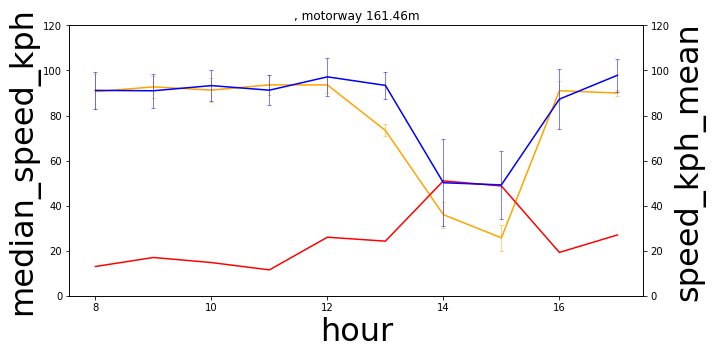

In [63]:
plot_dayline(u=u, v=v, day=21)

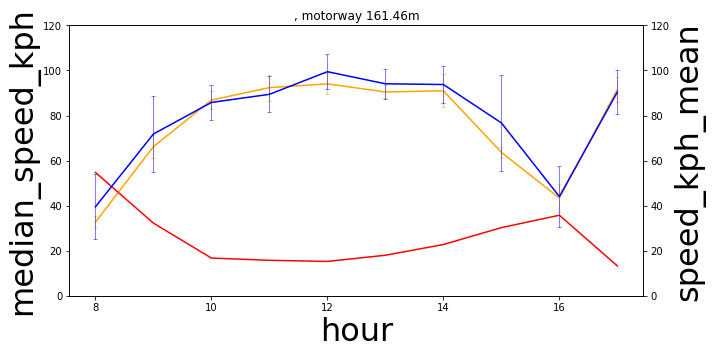

In [64]:
plot_dayline(u=u, v=v, day=22)

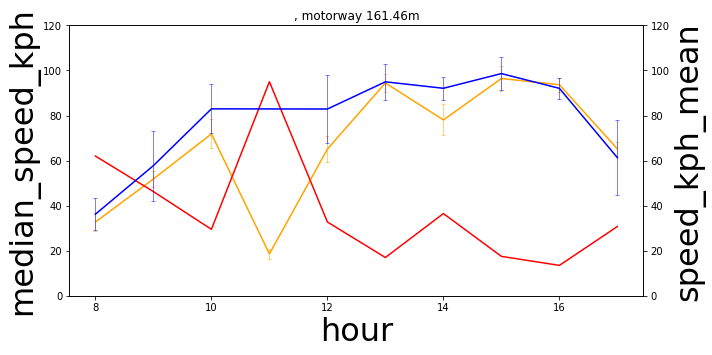

In [65]:
plot_dayline(u=u, v=v, day=23)

## KDE

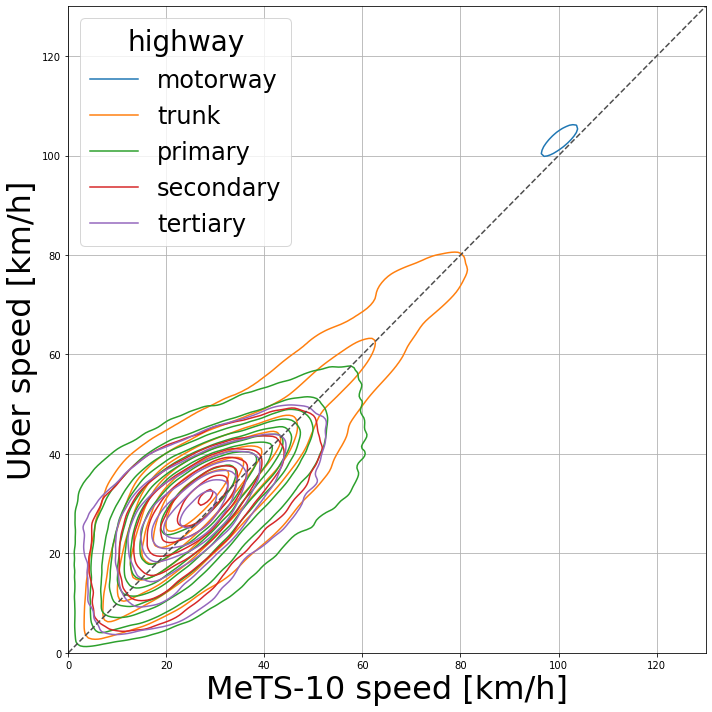

In [66]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.kdeplot(
    data=ut_merged[[simplified_filter(hw) and "link" not in hw for hw in ut_merged["highway"]]], x="median_speed_kph", y="speed_kph_mean", hue="highway", ax=ax
)
ax.plot([0, 130], [0, 130], ls="--", c=".3")
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid(axis="both")
ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_kde_highway_non_links.pdf")

In [67]:
# fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
# sns.kdeplot(
#     data=ut_merged[[simplified_filter(hw) and "link" in hw for hw in ut_merged["highway"]]], x="median_speed_kph", y="speed_kph_mean", hue="highway", ax=ax
# )
# ax.plot([0, 130], [0, 130], ls="--", c=".3")
# ax.set_xlim([0, 130])
# ax.set_ylim([0, 130])
# ax.grid(axis="both")
# ax.set(xlabel='MeTS-10 speed [km/h]',
#        ylabel='Uber speed [km/h]')
# plt.savefig(f"{CITY.title()}_Uber_kde_highway_links.pdf")

/tmp/ipykernel_59208/687453266.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{CITY.title()}_Uber_scatter_highway.png")
/home/che/miniconda3/envs/t4c22/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


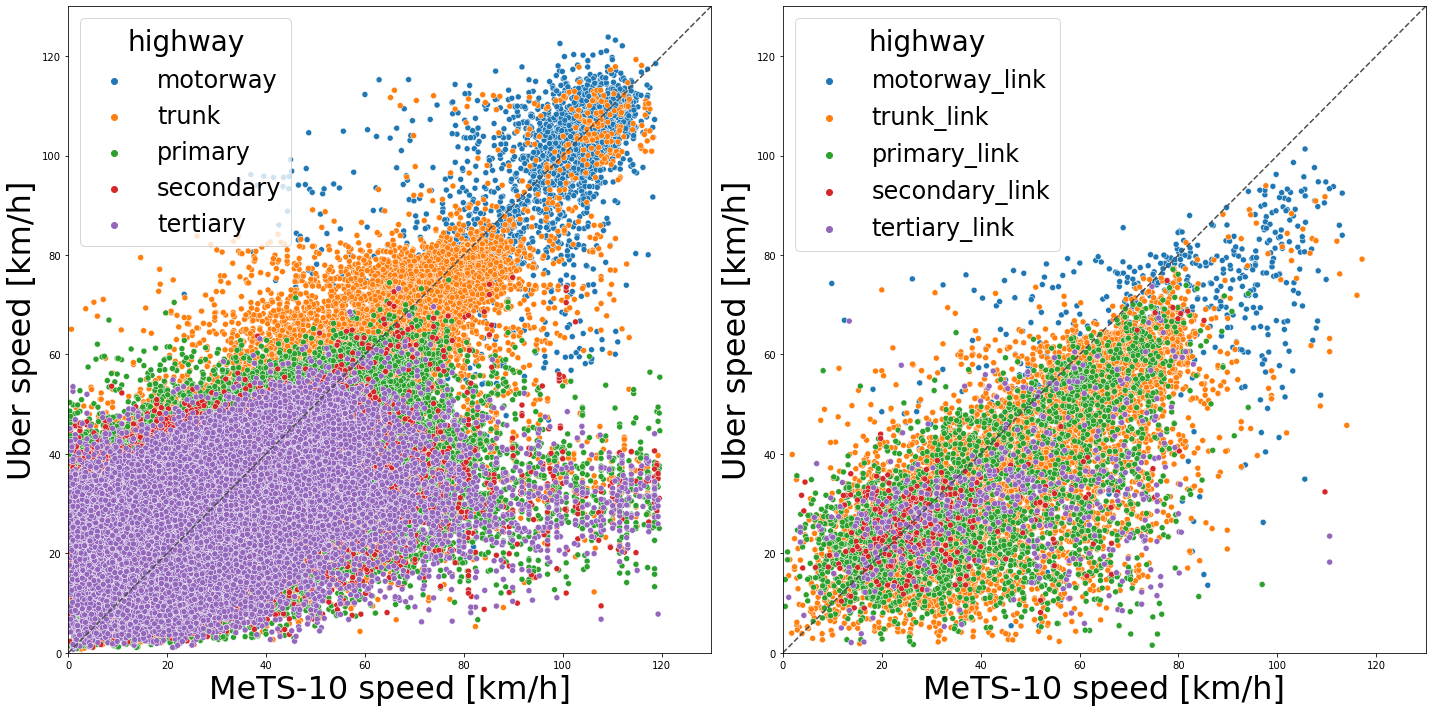

In [95]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
ax0, ax1 = axs
sns.scatterplot(
    data=ut_merged[[simplified_filter(hw) and "link" not in hw for hw in ut_merged["highway"]] & (ut_merged["day"] == END_DAY)],
    x="median_speed_kph",
    y="speed_kph_mean",
    hue="highway",
    ax=ax0,
)
sns.scatterplot(
    data=ut_merged[[simplified_filter(hw) and "link" in hw for hw in ut_merged["highway"]] & (ut_merged["day"] == END_DAY)],
    x="median_speed_kph",
    y="speed_kph_mean",
    hue="highway",
    ax=ax1,
)

for ax in axs:
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 130])
    ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
    
plt.savefig(f"{CITY.title()}_Uber_scatter_highway.png")

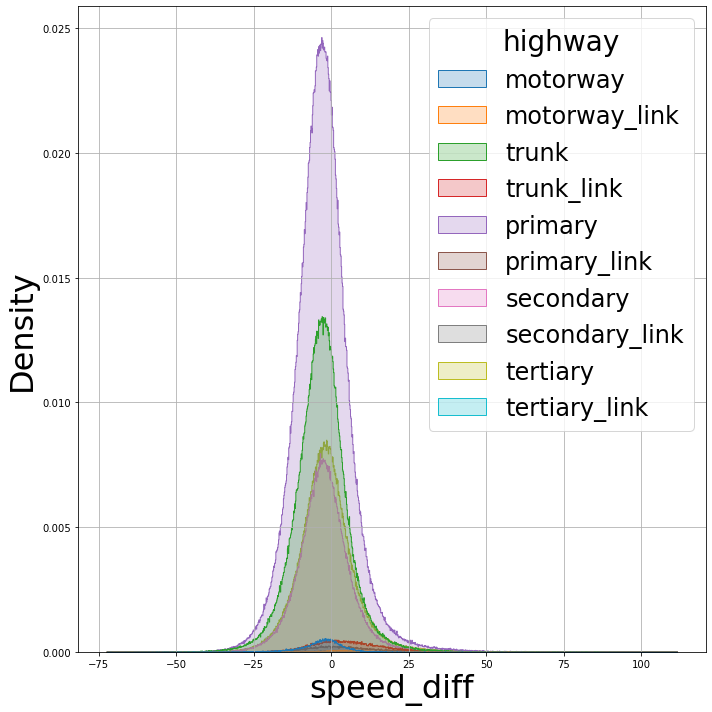

In [69]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.histplot(data=ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]], x="speed_diff", hue="highway", element="step", stat="density")
# ax.set_yscale('log')
ax.grid()
plt.savefig(f"{CITY.title()}_Uber_histogram_highway.pdf")

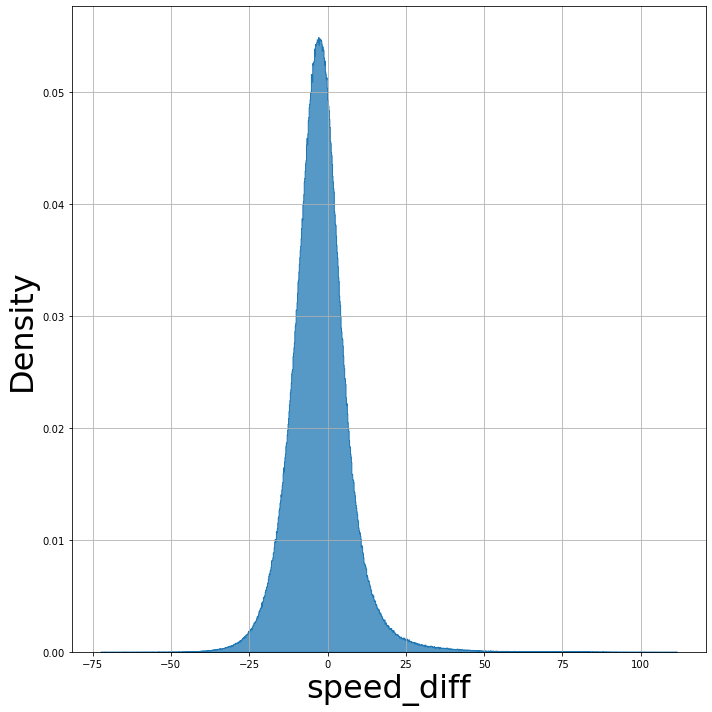

In [70]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.histplot(
    data=ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="speed_diff"
    #              , hue="highway"
    ,
    element="step",
    stat="density",
)
# ax.set_yscale('log')
ax.grid()
plt.savefig(f"{CITY.title()}_Uber_histogram.pdf")

## Inspect extreme cases (speed_diff > 10)

In [71]:
df_cell_mapping = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_intersecting_cells.parquet")
df_cell_mapping

gkey           u           v      osmid  \
0              78112_25508583_129375498       78112    25508583  129375498   
1              78112_25508584_129375498       78112    25508584  129375498   
2            99936_2146383887_204647020       99936  2146383887  204647020   
3            99936_4544836433_233623258       99936  4544836433  233623258   
4                  99937_200047_4257261       99937      200047    4257261   
...                                 ...         ...         ...        ...   
234303   6577730921_254761207_358627524  6577730921   254761207  358627524   
234304    6577730921_6577730928_8227762  6577730921  6577730928    8227762   
234305     6577730928_2379175_700435511  6577730928     2379175  700435511   
234306    6577745911_36728211_646234311  6577745911    36728211  646234311   
234307  6577745911_5930672687_646234311  6577745911  5930672687  646234311   

        speed_kph maxspeed       highway oneway lanes tunnel  length_meters  \
0            40.4           unclassified                          19.407060   
1            40.4           unclassified                          63.857249   
2            48.3   30 mph  unclassified                          12.645031   
3            48.3   30 mph  unclassified                          47.220818   
4            48.3   30 mph  unclassified                          59.033945   
...           ...      ...           ...    ...   ...    ...            ...   
234303       46.2               tertiary                         134.082828   
234304       36.3            residential                          51.325126   
234305       36.3            residential                          57.576832   
234306       48.3   30 mph       primary                         305.243521   
234307       48.3   30 mph       primary                          90.750571   

                                                 geometry            name  \
0       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...    Outer Circle   
1       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...    Outer Circle   
2       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x94o\x1...       York Gate   
3       b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x94o\x1...       York Gate   
4       b'\x01\x02\x00\x00\x00\x07\x00\x00\x005\x9a\\\...       York Gate   
...                                                   ...             ...   
234303  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdfw\xc...   Golborne Road   
234304  b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xdfw\xc...  Bevington Road   
234305  b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x96\x7f...  Bevington Road   
234306  b'\x01\x02\x00\x00\x00\x07\x00\x00\x00\x82\xdb...     Coombe Lane   
234307  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x82\xdb...     Coombe Lane   

        geometry_reversed                                 intersecting_cells  
0                   False  [(172, 223, 2, 0.0), (173, 223, 2, 1.0), (173,...  
1                   False  [(173, 223, 0, 0.041804563658226324), (172, 22...  
2                   False                               [(176, 216, 0, 1.0)]  
3                   False  [(175, 216, 1, 0.037851813122377106), (175, 21...  
4                   False  [(176, 217, 3, 0.0), (176, 216, 1, 1.0), (176,...  
...                   ...                                                ...  
234303              False  [(178, 159, 0, 0.4780438104955831), (178, 160,...  
234304              False  [(178, 160, 2, 0.0), (178, 159, 0, 1.0), (178,...  
234305              False  [(178, 160, 3, 0.0), (178, 159, 1, 1.0), (178,...  
234306              False  [(289, 130, 2, 0.38704878562390743), (288, 130...  
234307              False  [(288, 128, 1, 0.6690288713917689), (288, 129,...  

[234308 rows x 15 columns]

In [72]:
cols = [
    "year",
    "month",
    "day",
    "hour",
    "speed_diff",
    "std_speed_kph",
    "median_speed_kph",
    "speed_kph_mean",
    "free_flow_kph",
    "speed_kph",
    "length_meters",
    "x_u",
    "y_u",
    "x_v",
    "y_v",
]

extreme_edges = (
    ut_merged[ut_merged["speed_diff"] > 10]
    .groupby(["u", "v", "gkey"])
    .agg(**{col: (col, "mean") for col in cols}, count=("year", "count"), name=("name", "first"))
    .reset_index()[cols + ["name", "count", "u", "v", "gkey"]]
    .sort_values("speed_diff", ascending=False)
)
extreme_edges = extreme_edges[extreme_edges["count"] > 1]
extreme_edges

year  month   day  hour  speed_diff  std_speed_kph  median_speed_kph  \
28121  2019.0   10.0  22.5  11.0   88.032703       0.000000        115.294118   
49310  2019.0   10.0  26.5  10.0   86.338585       0.000000        116.235294   
24903  2019.0   10.0  25.5  12.5   84.316593       4.235294        115.764706   
13248  2019.0   10.0  25.0  12.5   81.935733       2.352941        111.294118   
27804  2019.0   10.0  26.5  10.0   78.765570       5.920168        117.764706   
...       ...    ...   ...   ...         ...            ...               ...   
35667  2019.0   10.0  25.0  16.5   10.063672       1.588235         37.000000   
2745   2019.0   10.0  24.0  12.5   10.049486       5.529412         29.764706   
13309  2019.0   10.0  25.0  14.0   10.040619       9.241539         60.117647   
23457  2019.0   10.0  25.5  14.5   10.028745       0.000000         25.882353   
61641  2019.0   10.0  25.5  14.5   10.019325       1.019608         45.529412   

       speed_kph_mean  free_flow_kph  speed_kph  length_meters       x_u  \
28121       27.261415      30.588235       32.2      79.060175 -0.232092   
49310       29.896709      32.941176       46.2      68.526761  0.055778   
24903       31.448113      30.588235       48.3      63.808651 -0.005224   
13248       29.358385      32.000000       32.2     148.347734 -0.189523   
27804       38.999136      35.764706       46.2      89.821128  0.056515   
...               ...            ...        ...            ...       ...   
35667       26.936328      27.647059       32.2      55.919352 -0.092069   
2745        19.715220      29.647059       32.2     117.259897 -0.100924   
13309       50.077028      57.882353       64.4     929.171668 -0.114574   
23457       15.853608      19.529412       46.2      24.726212 -0.288332   
61641       35.510087      30.431373       32.2      18.749827 -0.244766   

             y_u       x_v        y_v                 name  count           u  \
28121  51.506305 -0.232798  51.506393        Uxbridge Road      2   185712417   
49310  51.580753  0.055215  51.580502  Redbridge Lane East      2  2145776600   
24903  51.554062 -0.005114  51.553499     High Road Leyton      2    99349425   
13248  51.552717 -0.190811  51.552368        West End Lane      2    25291140   
27804  51.581082  0.055778  51.580753  Redbridge Lane East      2   149527698   
...          ...       ...        ...                  ...    ...         ...   
35667  51.547948 -0.091877  51.548413         Wallace Road      2   475413343   
2745   51.575163 -0.099878  51.575301        Endymion Road      2      199449   
13309  51.653646 -0.122744  51.651891         Enfield Road      2    25307025   
23457  51.502981 -0.288521  51.502864    Gunnersbury Drive      2    71575268   
61641  51.399410 -0.244599  51.399427      Burlington Road      2  6471221781   

                v                             gkey  
28121   185741438    185712417_185741438_371339739  
49310    13982840      2145776600_13982840_4262989  
24903    99356048      99349425_99356048_663703203  
13248    25291139      25291140_25291139_297376896  
27804  2145776600     149527698_2145776600_4262989  
...           ...                              ...  
35667  1991118880   475413343_1991118880_227833720  
2745       199450           199449_199450_22605738  
13309     7028260        25307025_7028260_24214475  
23457    71575267        71575268_71575267_9401528  
61641  6469344611  6471221781_6469344611_689603861  

[39312 rows x 20 columns]

In [73]:
def show_marker_on_map(lat, lon, lat2, lon2):
    pt = (lat, lon)
    pt2 = (lat2, lon2)
    bb = [(lat - 0.001, lon - 0.001), (lat + 0.001, lon + 0.001)]
    f = folium.Figure(width=930, height=300)
    m = folium.Map().add_to(f)
    folium.Marker(pt).add_to(m)
    folium.Marker(pt2).add_to(m)
    # folium.PolyLine(line, weight=5, opacity=1).add_to(m)
    m.fit_bounds(bb)
    return m


def visualize_extreme_case(i, extreme_edges=extreme_edges):
    item = extreme_edges.iloc[i]
    print(item)
    print("intersecting_cells")
    ic = df_cell_mapping[(df_cell_mapping["gkey"] == item["gkey"])]
    assert len(ic) == 1
    ic = ic.iloc[0]
    for ic in ast.literal_eval(ic["intersecting_cells"]):
        print(f"  {ic}")
    fig, ax = plt.subplots(1, tight_layout=True, figsize=(20, 10))
    data = ut_merged[(ut_merged["u"] == item["u"]) & (ut_merged["v"] == item["v"]) & (ut_merged["gkey"] == item["gkey"])]
    ax.plot(range(len(data)), data["median_speed_kph"], label="median_speed_kph", color="red")
    ax.plot(range(len(data)), data["speed_kph_mean"], label="speed_kph_mean", color="orange")
    ax.plot(range(len(data)), data["std_speed_kph"], label="std_speed_kph", color="green")
    ax.plot(range(len(data)), data["speed_mph_stddev"], label="speed_mph_stddev", color="yellow")
    ax.axhline(item["free_flow_kph"], label="free_flow_kph", color="black")
    ax.axhline(item["speed_kph"], label="speed_kph", color="grey", linestyle="dashed")
    ax.bar(range(len(data)), data["volume"], color="blue", label="volume")
    ax.legend()
    return show_marker_on_map(item["y_u"], item["x_u"], item["y_v"], item["x_v"])

year                                       2019.0
month                                        10.0
day                                          22.5
hour                                         11.0
speed_diff                              88.032703
std_speed_kph                                 0.0
median_speed_kph                       115.294118
speed_kph_mean                          27.261415
free_flow_kph                           30.588235
speed_kph                                    32.2
length_meters                           79.060175
x_u                                     -0.232092
y_u                                     51.506305
x_v                                     -0.232798
y_v                                     51.506393
name                                Uxbridge Road
count                                           2
u                                       185712417
v                                       185741438
gkey                185712417_185741438_371339739


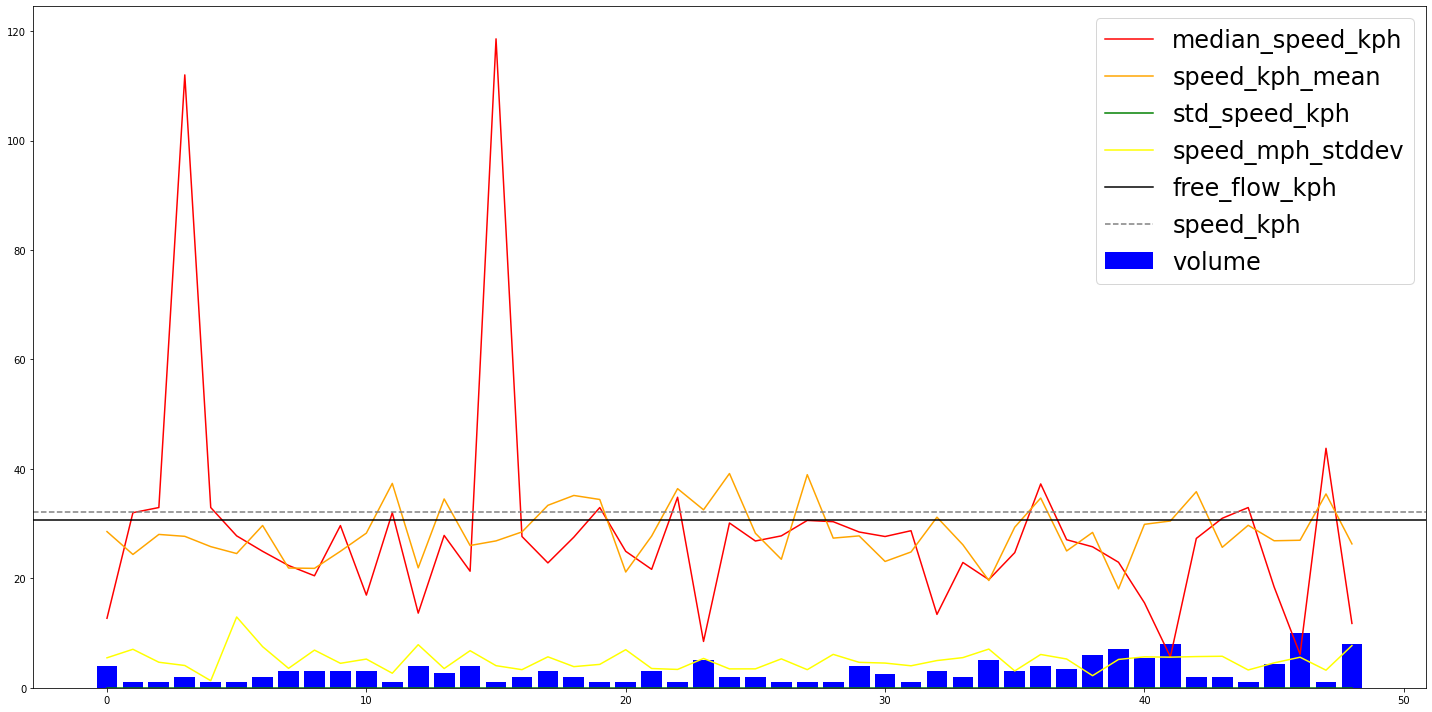

In [74]:
visualize_extreme_case(0)

year                                         2019.0
month                                          10.0
day                                            23.5
hour                                            8.5
speed_diff                                63.333904
std_speed_kph                                   0.0
median_speed_kph                          95.058824
speed_kph_mean                            31.724919
free_flow_kph                             33.882353
speed_kph                                      32.2
length_meters                              19.41766
x_u                                        -0.10762
y_u                                       51.511027
x_v                                       -0.107466
y_v                                       51.511108
name                            Victoria Embankment
count                                             2
u                                        4166662878
v                                        4696544885
gkey        

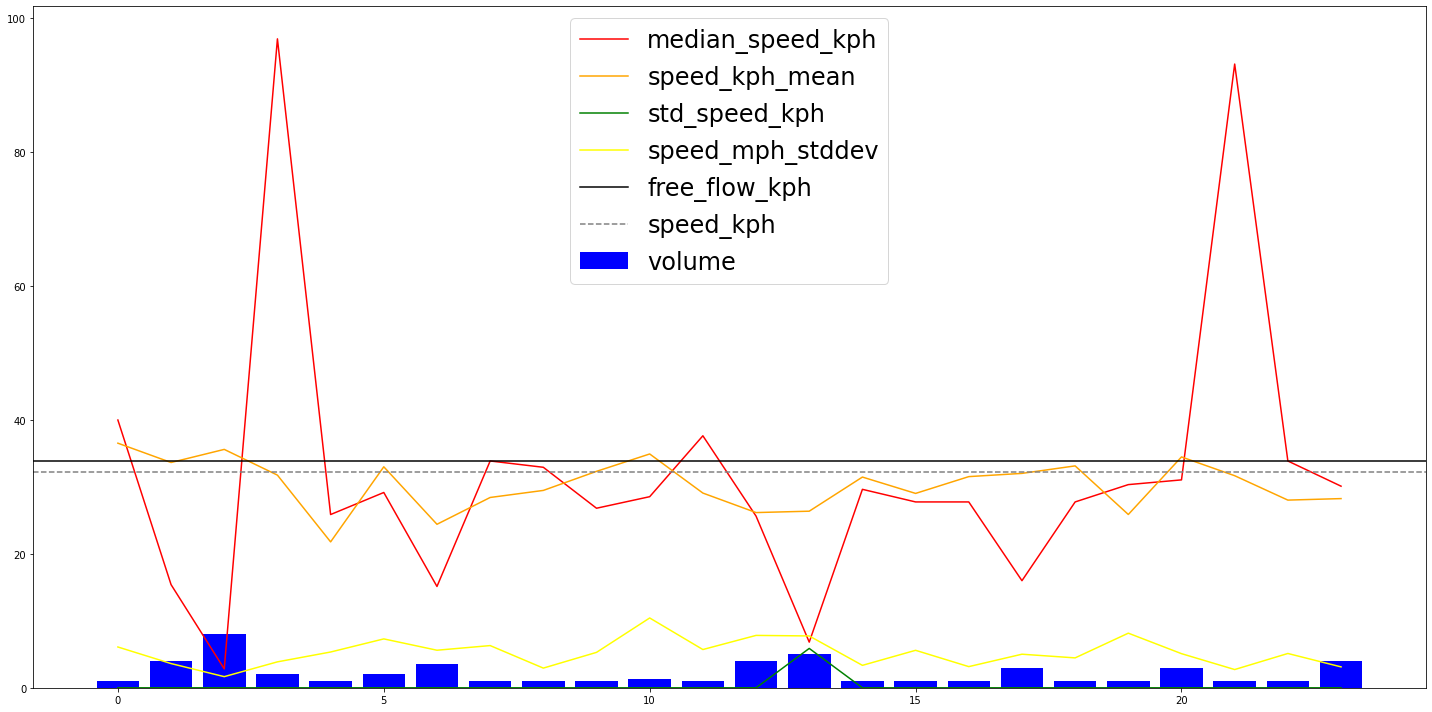

In [75]:
visualize_extreme_case(55)

year                                       2019.0
month                                        10.0
day                                          26.0
hour                                         14.0
speed_diff                              57.369986
std_speed_kph                            3.647059
median_speed_kph                        72.352941
speed_kph_mean                          14.982955
free_flow_kph                                40.0
speed_kph                                    48.3
length_meters                           47.104244
x_u                                     -0.365572
y_u                                     51.549404
x_v                                     -0.365971
y_v                                     51.549263
name                              Mandeville Road
count                                           2
u                                        25628830
v                                      3091468698
gkey                25628830_3091468698_226117648


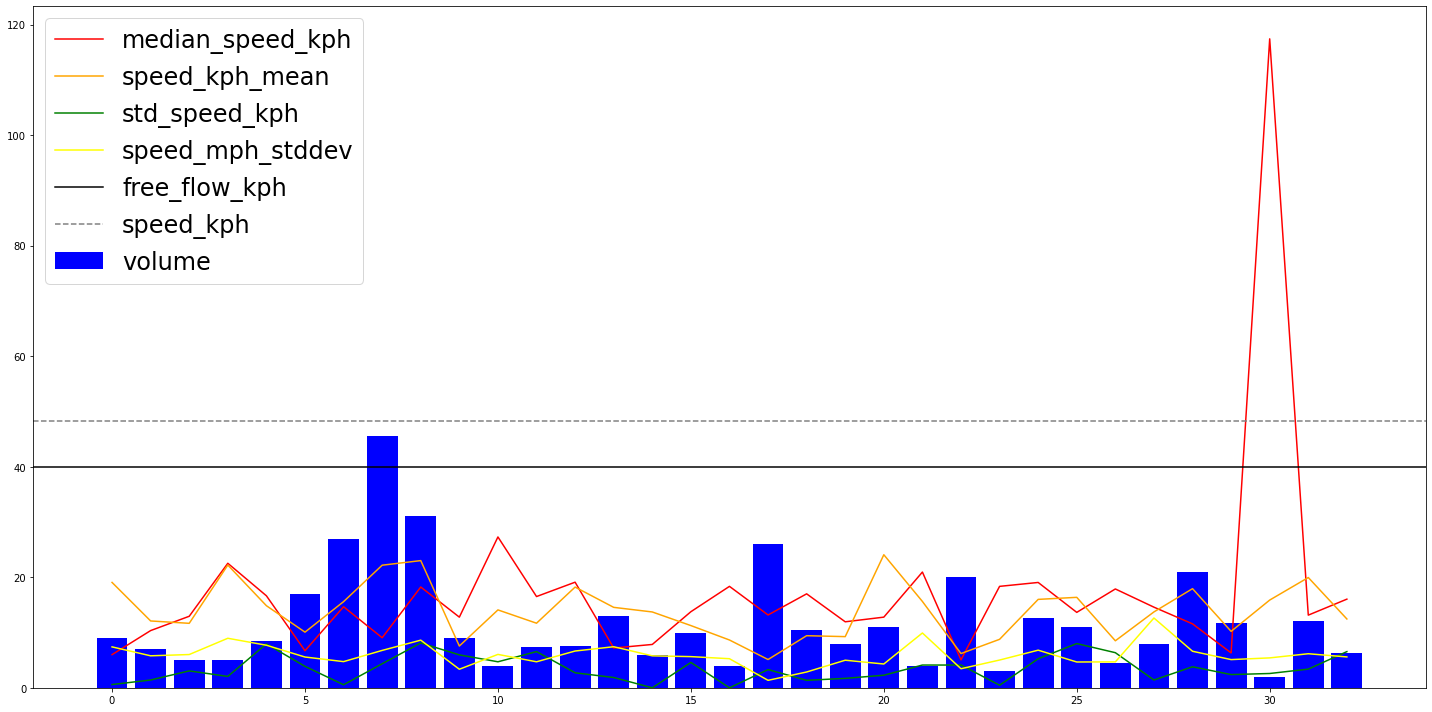

In [76]:
visualize_extreme_case(105)

year                                     2019.0
month                                      10.0
day                                        25.0
hour                                       12.5
speed_diff                            81.935733
std_speed_kph                          2.352941
median_speed_kph                     111.294118
speed_kph_mean                        29.358385
free_flow_kph                              32.0
speed_kph                                  32.2
length_meters                        148.347734
x_u                                   -0.189523
y_u                                   51.552717
x_v                                   -0.190811
y_v                                   51.552368
name                              West End Lane
count                                         2
u                                      25291140
v                                      25291139
gkey                25291140_25291139_297376896
Name: 13248, dtype: object
intersecting_

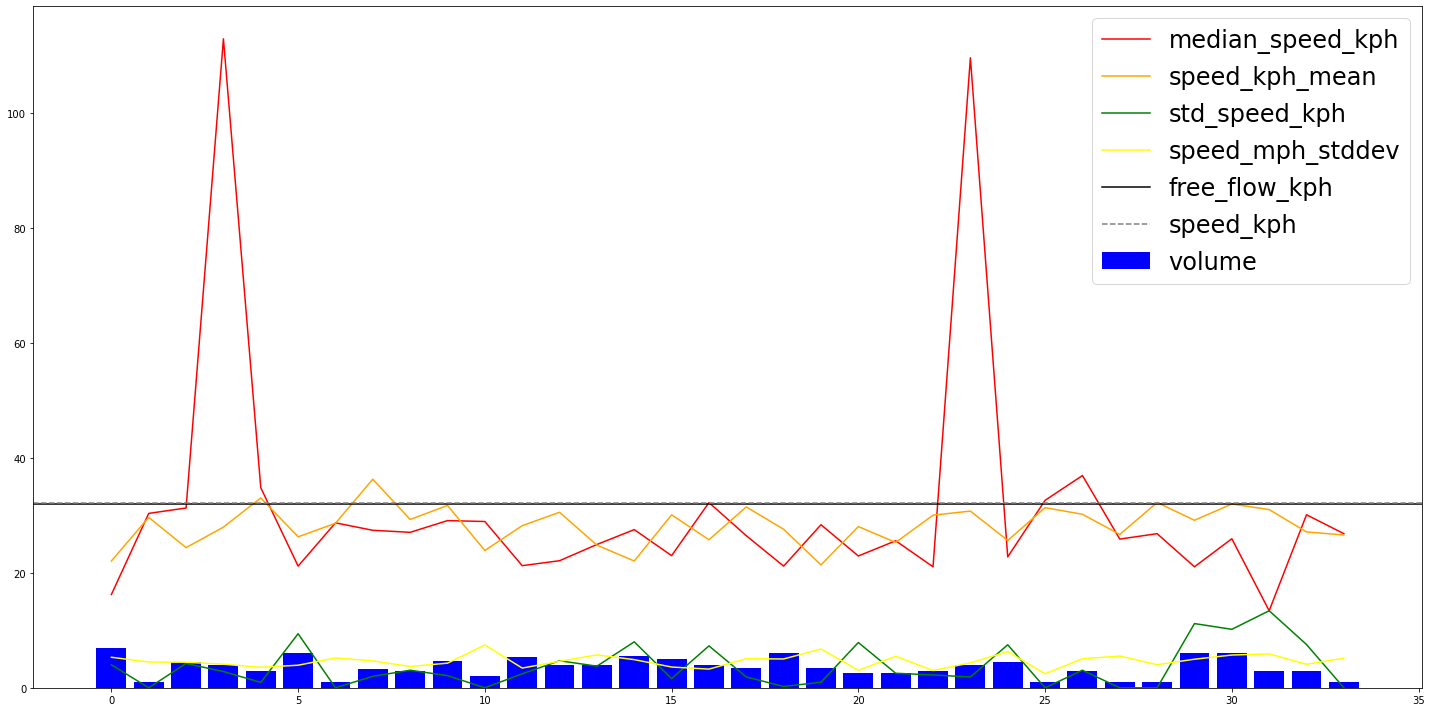

In [77]:
visualize_extreme_case(3)

year                                      2019.0
month                                       10.0
day                                         26.5
hour                                        10.0
speed_diff                              78.76557
std_speed_kph                           5.920168
median_speed_kph                      117.764706
speed_kph_mean                         38.999136
free_flow_kph                          35.764706
speed_kph                                   46.2
length_meters                          89.821128
x_u                                     0.056515
y_u                                    51.581082
x_v                                     0.055778
y_v                                    51.580753
name                         Redbridge Lane East
count                                          2
u                                      149527698
v                                     2145776600
gkey                149527698_2145776600_4262989
Name: 27804, dtype: 

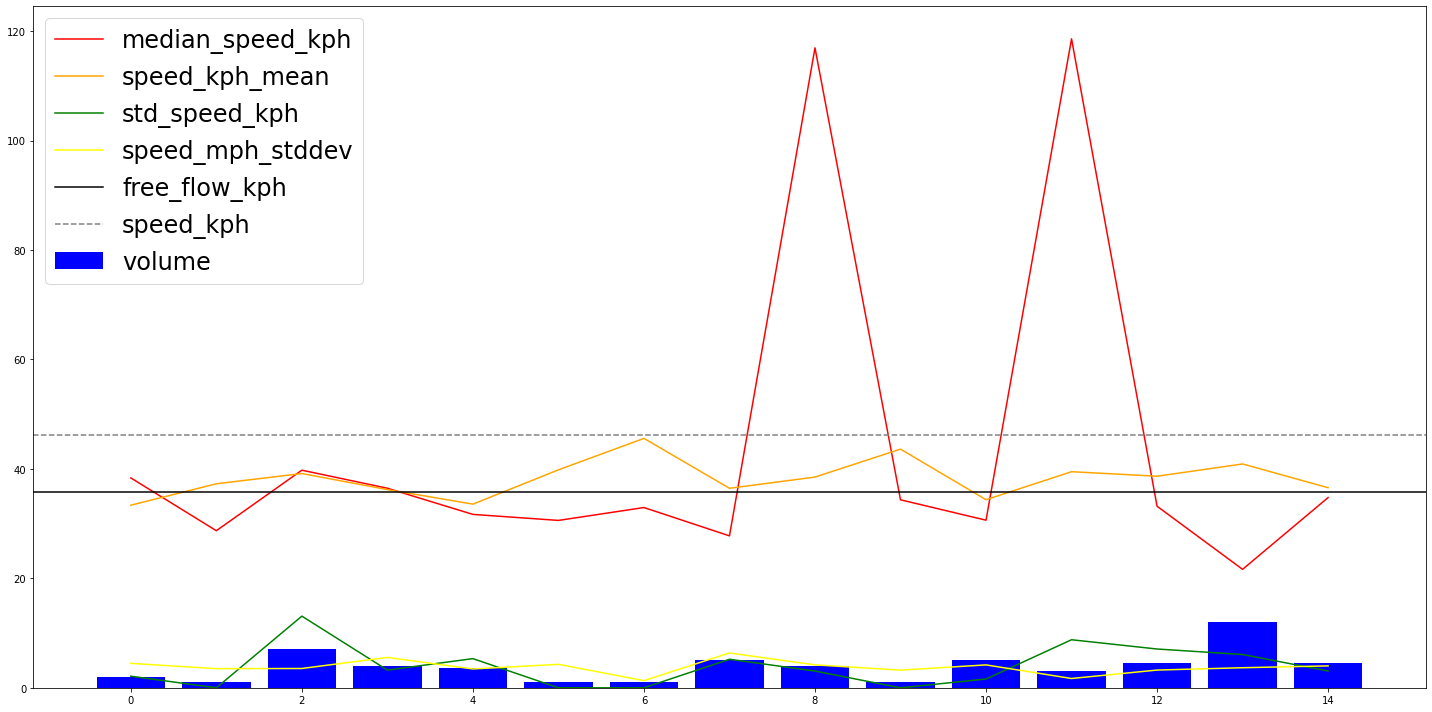

In [78]:
visualize_extreme_case(4)

year                                   2019.0
month                                    10.0
day                                      25.0
hour                                      9.5
speed_diff                          78.237951
std_speed_kph                        0.588235
median_speed_kph                   115.647059
speed_kph_mean                      37.409108
free_flow_kph                       33.882353
speed_kph                                32.2
length_meters                      201.685049
x_u                                 -0.103364
y_u                                 51.399986
x_v                                  -0.10486
y_v                                 51.401011
name                             Melfort Road
count                                       2
u                                    27351936
v                                    27352028
gkey                27351936_27352028_8415883
Name: 17815, dtype: object
intersecting_cells
  (300, 265, 1, 0.0137971024455104

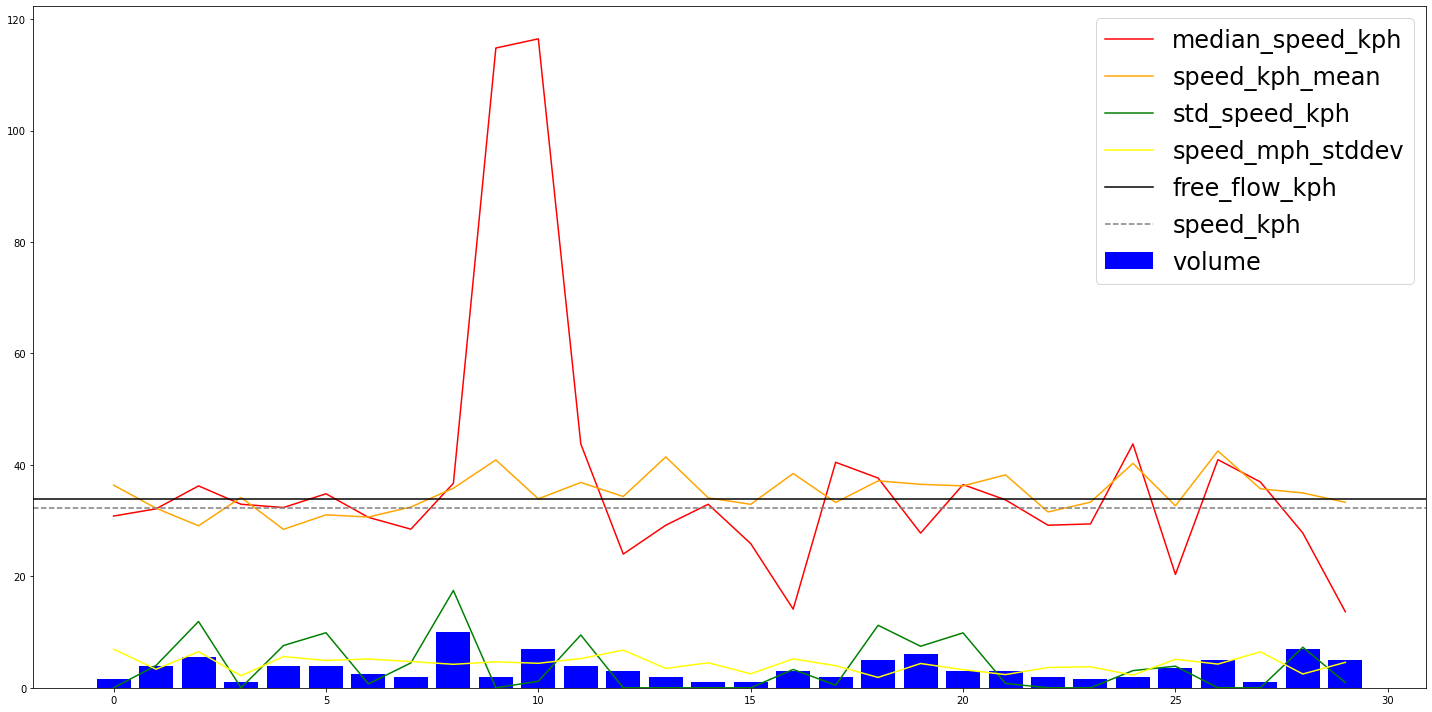

In [79]:
visualize_extreme_case(5)

year                                  2019.0
month                                   10.0
day                                     24.5
hour                                     9.5
speed_diff                         71.692744
std_speed_kph                      13.882353
median_speed_kph                  101.882353
speed_kph_mean                     30.189609
free_flow_kph                      21.647059
speed_kph                               48.3
length_meters                      71.423292
x_u                                -0.158436
y_u                                51.519092
x_v                                -0.157802
y_v                                51.519199
name                           Dorset Street
count                                      2
u                                     275423
v                                  298207193
gkey                275423_298207193_4253850
Name: 4221, dtype: object
intersecting_cells
  (180, 210, 0, 0.6878814291346372)
  (180, 211, 0, 0.3

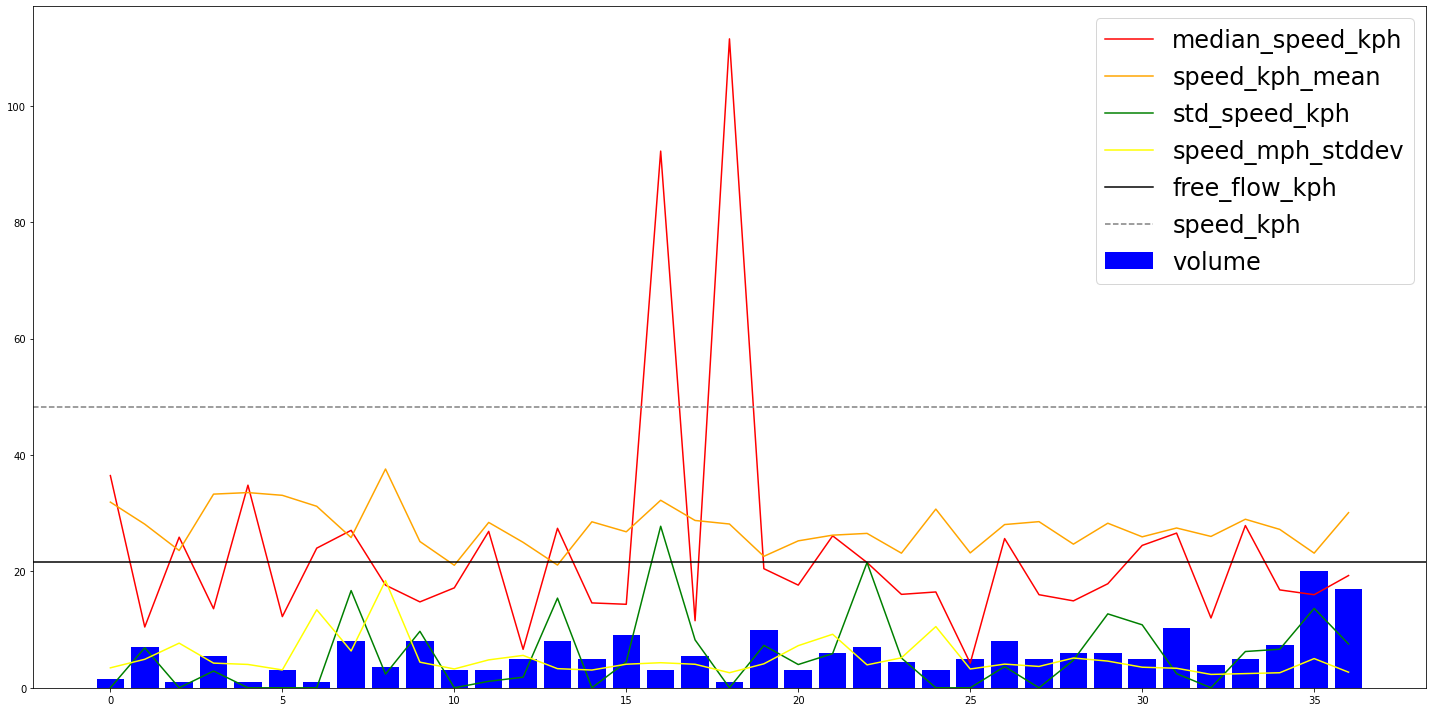

In [80]:
visualize_extreme_case(15)

## Inspect extreme cases (speed_diff < -10 and median_speed_kph < 15)

In [81]:
cols = [
    "year",
    "month",
    "day",
    "hour",
    "speed_diff",
    "std_speed_kph",
    "median_speed_kph",
    "speed_kph_mean",
    "free_flow_kph",
    "speed_kph",
    "length_meters",
    "x_u",
    "y_u",
    "x_v",
    "y_v",
]

extreme_edges_low = (
    ut_merged[(ut_merged["speed_diff"] < -10) & (ut_merged["median_speed_kph"] < 15)]
    .groupby(["u", "v", "gkey"])
    .agg(**{col: (col, "mean") for col in cols}, count=("year", "count"), name=("name", "first"), highway=("highway", "first"))
    .reset_index()[cols + ["name", "count", "u", "v", "gkey", "highway"]]
    .sort_values("speed_diff", ascending=True)
)
extreme_edges_low = extreme_edges_low[extreme_edges_low["count"] > 1]
extreme_edges_low

year  month   day       hour  speed_diff  std_speed_kph  \
4203   2019.0   10.0  26.0  11.333333  -59.466194      16.442566   
40004  2019.0   10.0  24.5  10.500000  -58.452122       0.000000   
20620  2019.0   10.0  24.5  14.500000  -56.941379       0.000000   
39052  2019.0   10.0  23.0  14.000000  -53.711767       6.088235   
16004  2019.0   10.0  27.0  15.000000  -51.183644      10.867195   
...       ...    ...   ...        ...         ...            ...   
40463  2019.0   10.0  23.5  14.500000  -10.092184       6.873519   
15695  2019.0   10.0  26.0  15.000000  -10.077709       1.294118   
31843  2019.0   10.0  24.0  11.500000  -10.070841       3.117647   
10617  2019.0   10.0  22.5  11.500000  -10.070076       3.000000   
10970  2019.0   10.0  26.0  12.500000  -10.010268       0.000000   

       median_speed_kph  speed_kph_mean  free_flow_kph  speed_kph  ...  \
4203           7.930283       67.396477      72.941176       80.5  ...   
40004          9.676471       68.128593      65.411765       64.4  ...   
20620          6.794118       63.735497      17.882353       36.3  ...   
39052         13.813725       67.525492      20.000000       36.3  ...   
16004          7.882353       59.065997      58.823529       48.3  ...   
...                 ...             ...            ...        ...  ...   
40463         11.735294       21.827478      28.705882       32.2  ...   
15695         12.588235       22.665945      24.000000       36.3  ...   
31843         11.176471       21.247311      25.411765       48.3  ...   
10617         12.294118       22.364193      27.764706       32.2  ...   
10970          8.470588       18.480856      16.470588       32.2  ...   

            x_u        y_u       x_v        y_v                       name  \
4203   0.050827  51.455107  0.053296  51.455369  Rochester Way Relief Road   
40004 -0.182366  51.458718 -0.182579  51.458939               Trinity Road   
20620 -0.142236  51.494328 -0.142337  51.494501                Wilton Road   
39052 -0.075744  51.511170 -0.075678  51.510855             America Square   
16004 -0.235670  51.573757 -0.233551  51.572036               Edgware Road   
...         ...        ...       ...        ...                        ...   
40463 -0.058086  51.538919 -0.058015  51.538922              Exmouth Place   
15695 -0.160815  51.488808 -0.161999  51.488057      St. Leonard's Terrace   
31843 -0.031033  51.580058 -0.030825  51.580112                              
10617 -0.107128  51.501312 -0.106687  51.501224              Webber Street   
10970 -0.143307  51.558259 -0.142924  51.557868                  York Rise   

      count           u           v                             gkey  \
4203      3      432734      432731           432734_432731_22970524   
40004     4  5209614954  5209614956  5209614954_5209614956_538150370   
20620     4   245802474   810371985     245802474_810371985_67076654   
39052     2  4777885222  4777885221  4777885222_4777885221_485031956   
16004     2    42324714   242703635      42324714_242703635_22633180   
...     ...         ...         ...                              ...   
40463     2  5276609923   467761729   5276609923_467761729_545964843   
15695     2    37879363    37877761        37879363_37877761_5319173   
31843     2  1714747609  1714747635  1714747609_1714747635_220382211   
10617     2    25499047    24923325      25499047_24923325_407944600   
10970     2    25588274    25588275        25588274_25588275_4712648   

            highway  
4203          trunk  
40004         trunk  
20620   residential  
39052   residential  
16004       primary  
...             ...  
40463  unclassified  
15695   residential  
31843       primary  
10617   residential  
10970   residential  

[26177 rows x 21 columns]

year                                   2019.0
month                                    10.0
day                                      26.0
hour                                11.333333
speed_diff                         -59.466194
std_speed_kph                       16.442566
median_speed_kph                     7.930283
speed_kph_mean                      67.396477
free_flow_kph                       72.941176
speed_kph                                80.5
length_meters                      276.105364
x_u                                  0.050827
y_u                                 51.455107
x_v                                  0.053296
y_v                                 51.455369
name                Rochester Way Relief Road
count                                       3
u                                      432734
v                                      432731
gkey                   432734_432731_22970524
highway                                 trunk
Name: 4203, dtype: object
intersec

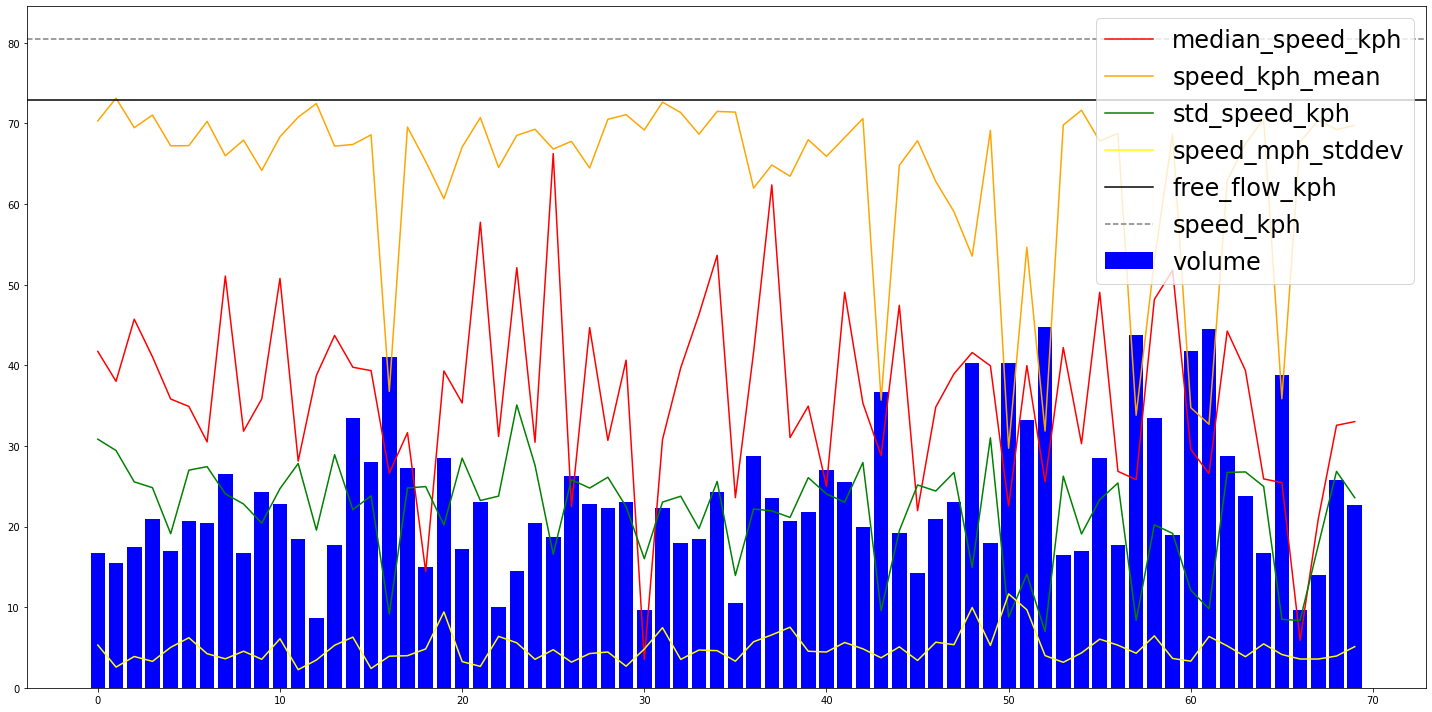

In [82]:
visualize_extreme_case(0, extreme_edges_low)

year                                         2019.0
month                                          10.0
day                                            24.5
hour                                           10.5
speed_diff                               -58.452122
std_speed_kph                                   0.0
median_speed_kph                           9.676471
speed_kph_mean                            68.128593
free_flow_kph                             65.411765
speed_kph                                      64.4
length_meters                             34.130031
x_u                                       -0.182366
y_u                                       51.458718
x_v                                       -0.182579
y_v                                       51.458939
name                                   Trinity Road
count                                             4
u                                        5209614954
v                                        5209614956
gkey        

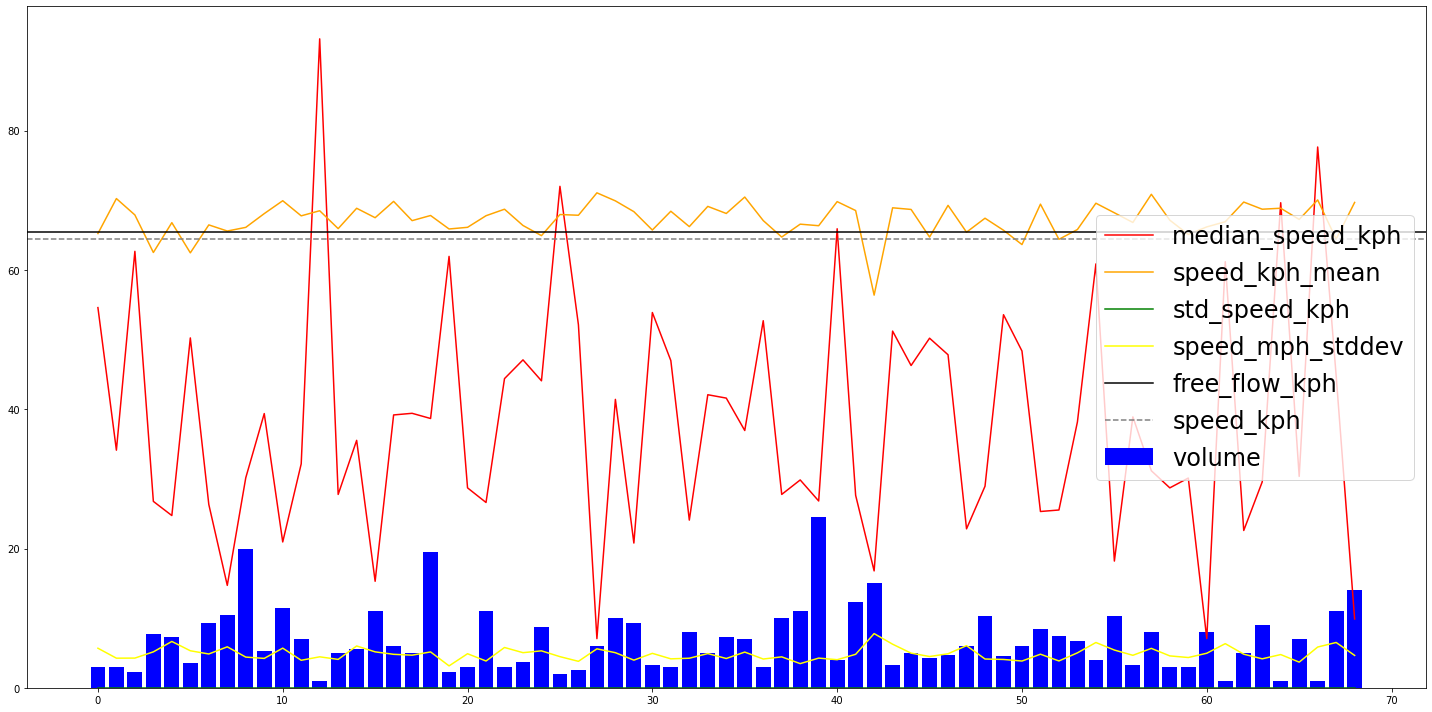

In [83]:
visualize_extreme_case(1, extreme_edges_low)

year                                      2019.0
month                                       10.0
day                                         24.5
hour                                        14.5
speed_diff                            -56.941379
std_speed_kph                                0.0
median_speed_kph                        6.794118
speed_kph_mean                         63.735497
free_flow_kph                          17.882353
speed_kph                                   36.3
length_meters                           22.22228
x_u                                    -0.142236
y_u                                    51.494328
x_v                                    -0.142337
y_v                                    51.494501
name                                 Wilton Road
count                                          4
u                                      245802474
v                                      810371985
gkey                245802474_810371985_67076654
highway             

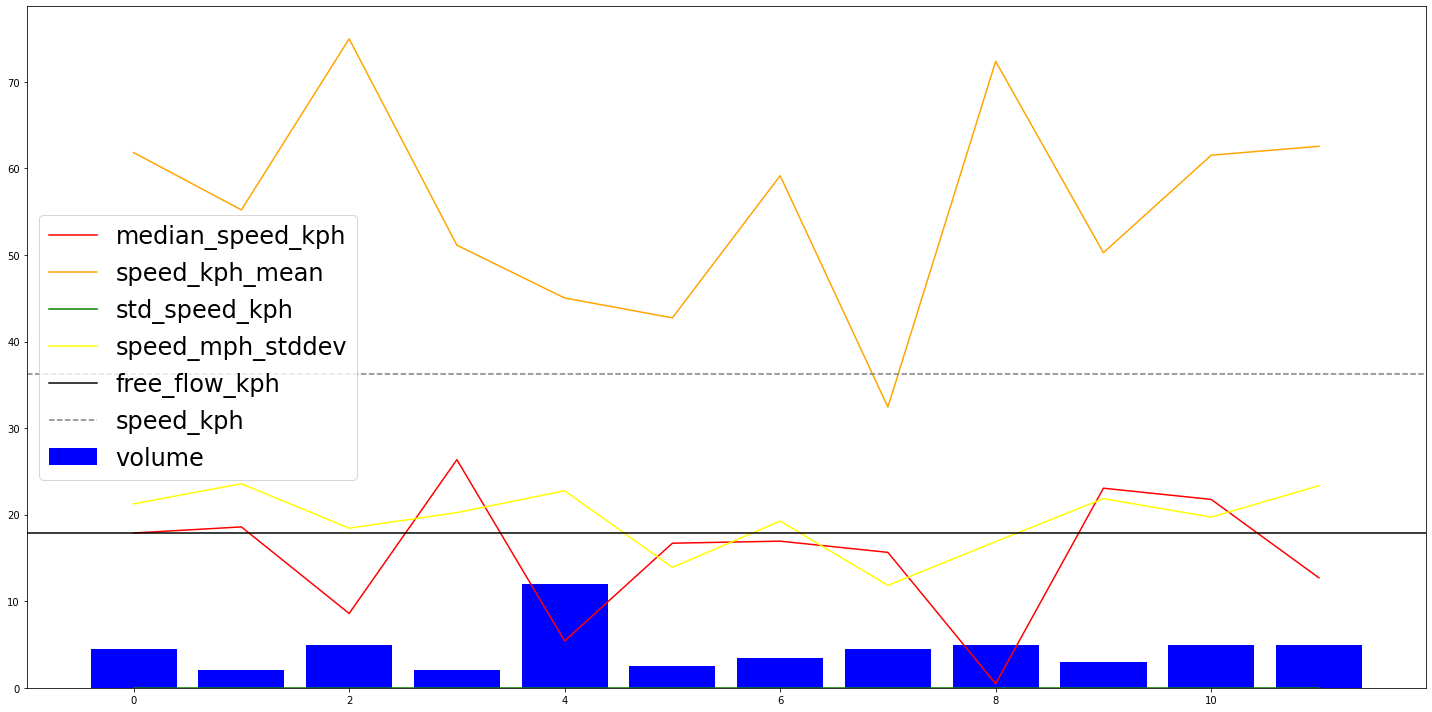

In [84]:
visualize_extreme_case(2, extreme_edges_low)

year                                        2019.0
month                                         10.0
day                                           22.5
hour                                     13.666667
speed_diff                              -38.721659
std_speed_kph                             4.263332
median_speed_kph                         10.482571
speed_kph_mean                           49.204229
free_flow_kph                            73.411765
speed_kph                                     64.4
length_meters                           127.898681
x_u                                      -0.092715
y_u                                      51.616108
x_v                                      -0.093863
y_v                                      51.616035
name                                              
count                                            6
u                                       1447888927
v                                        251610047
gkey                1447888927_

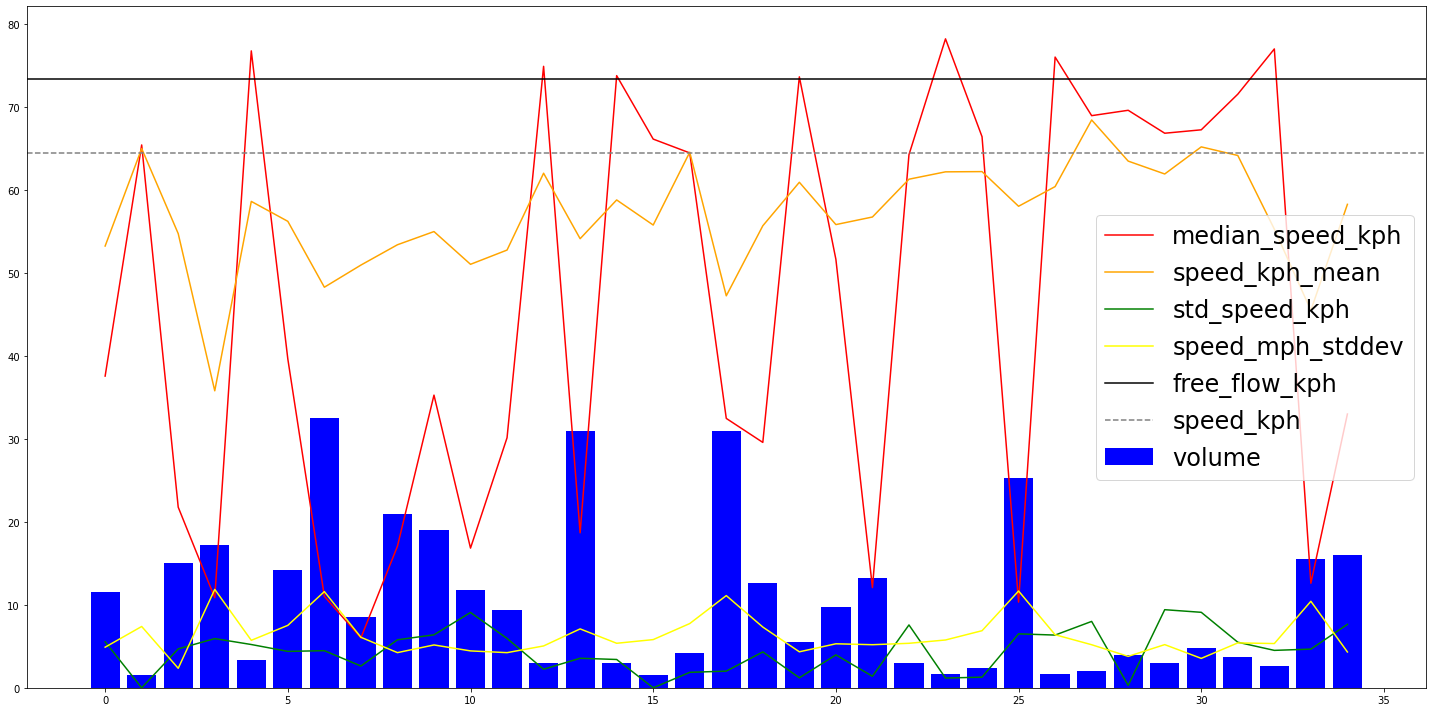

In [85]:
visualize_extreme_case(55, extreme_edges_low)

year                                        2019.0
month                                         10.0
day                                           27.0
hour                                          15.0
speed_diff                              -34.880412
std_speed_kph                             3.058824
median_speed_kph                          7.176471
speed_kph_mean                           42.056882
free_flow_kph                            47.294118
speed_kph                                     48.3
length_meters                             58.01353
x_u                                       -0.09605
y_u                                       51.35024
x_v                                      -0.095741
y_v                                      51.349819
name                              Sanderstead Road
count                                            2
u                                        128276605
v                                       1554897287
gkey                128276605_1

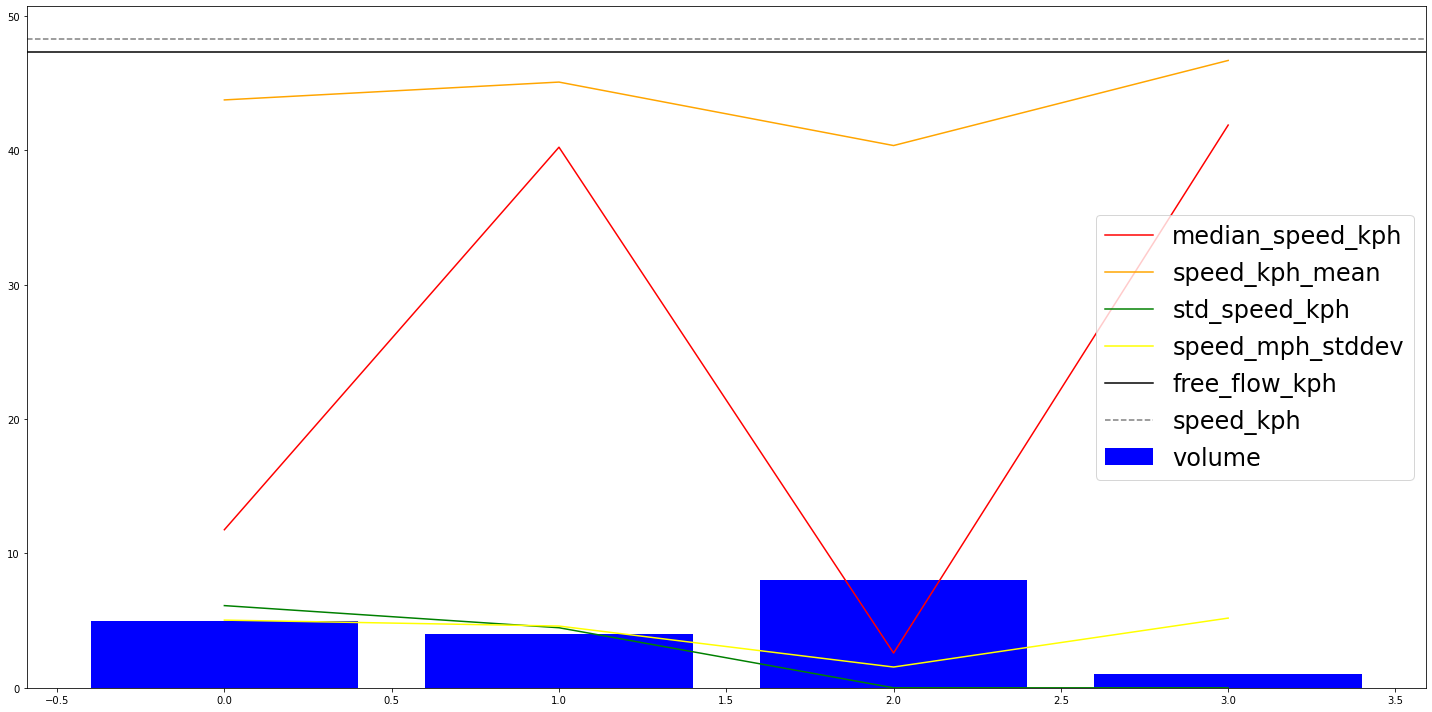

In [86]:
visualize_extreme_case(157, extreme_edges_low)

year                                       2019.0
month                                        10.0
day                                         25.25
hour                                         14.0
speed_diff                             -24.867304
std_speed_kph                            7.578431
median_speed_kph                         9.990196
speed_kph_mean                            34.8575
free_flow_kph                           26.823529
speed_kph                                    48.3
length_meters                           21.242384
x_u                                     -0.086003
y_u                                     51.380548
x_v                                     -0.085815
y_v                                     51.380585
name                                 Morland Road
count                                           4
u                                       107204933
v                                       107204935
gkey                107204933_107204935_122625727


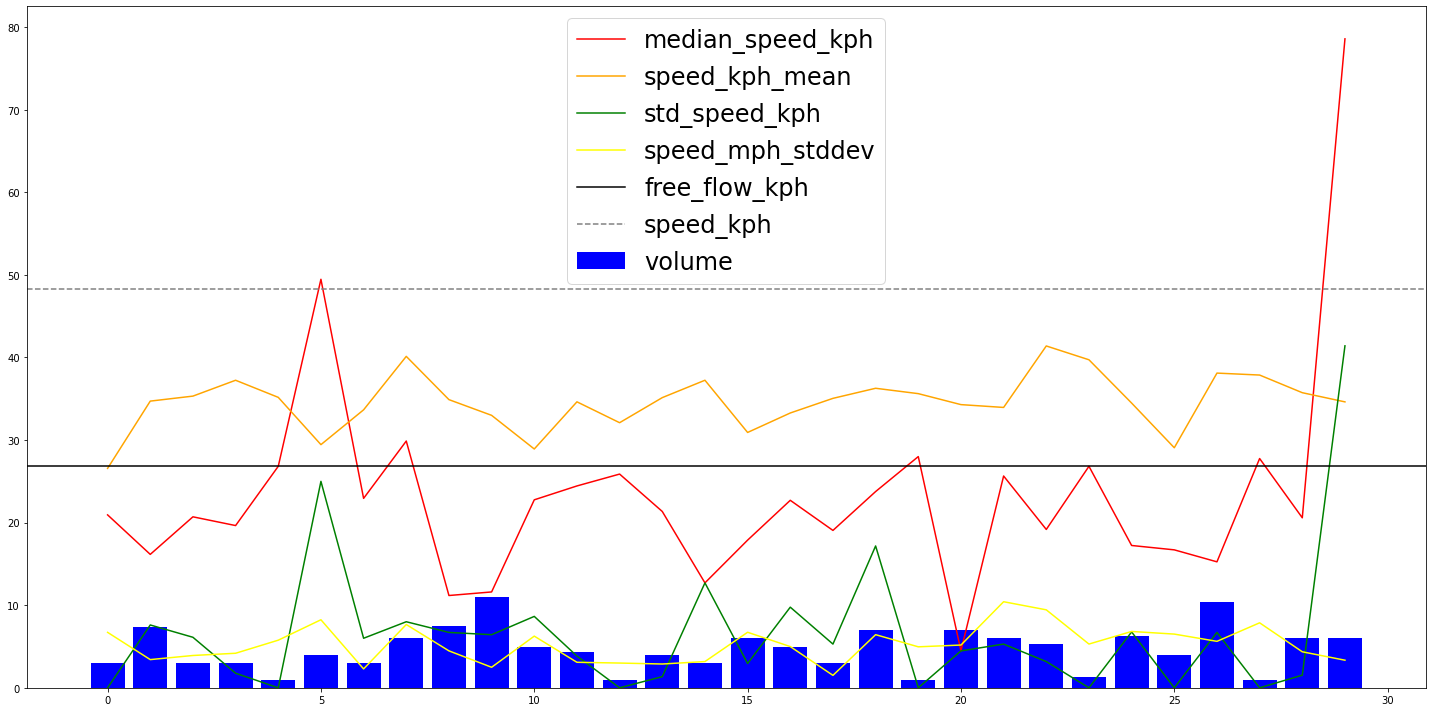

In [87]:
visualize_extreme_case(2000, extreme_edges_low)

year                                      2019.0
month                                       10.0
day                                    24.086957
hour                                   12.434783
speed_diff                             -20.71833
std_speed_kph                           5.020318
median_speed_kph                       11.269821
speed_kph_mean                         31.988151
free_flow_kph                          25.882353
speed_kph                                   48.3
length_meters                         104.327571
x_u                                    -0.170568
y_u                                    51.460131
x_v                                     -0.16967
y_v                                    51.460405
name                              Battersea Rise
count                                         23
u                                     4946959991
v                                       26479857
gkey                4946959991_26479857_42675697
highway             

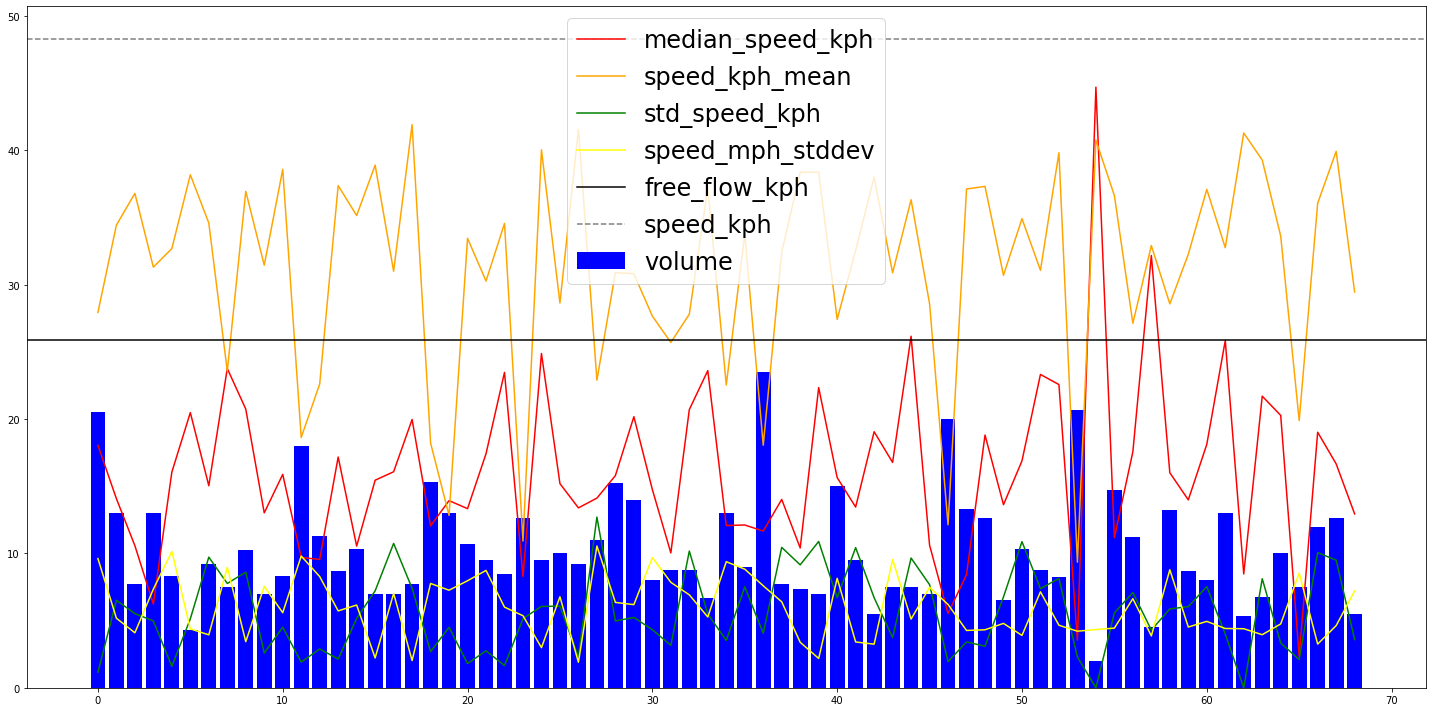

In [88]:
visualize_extreme_case(5000, extreme_edges_low)

year                                     2019.0
month                                      10.0
day                                        22.5
hour                                       12.5
speed_diff                           -17.381468
std_speed_kph                          1.509804
median_speed_kph                      10.843137
speed_kph_mean                        28.224605
free_flow_kph                              24.0
speed_kph                                  46.2
length_meters                         17.110785
x_u                                   -0.041003
y_u                                   51.628268
x_v                                   -0.041155
y_v                                    51.62829
name                        Pickett's Lock Lane
count                                         2
u                                    1430279210
v                                        920214
gkey                1430279210_920214_609317296
highway                                t

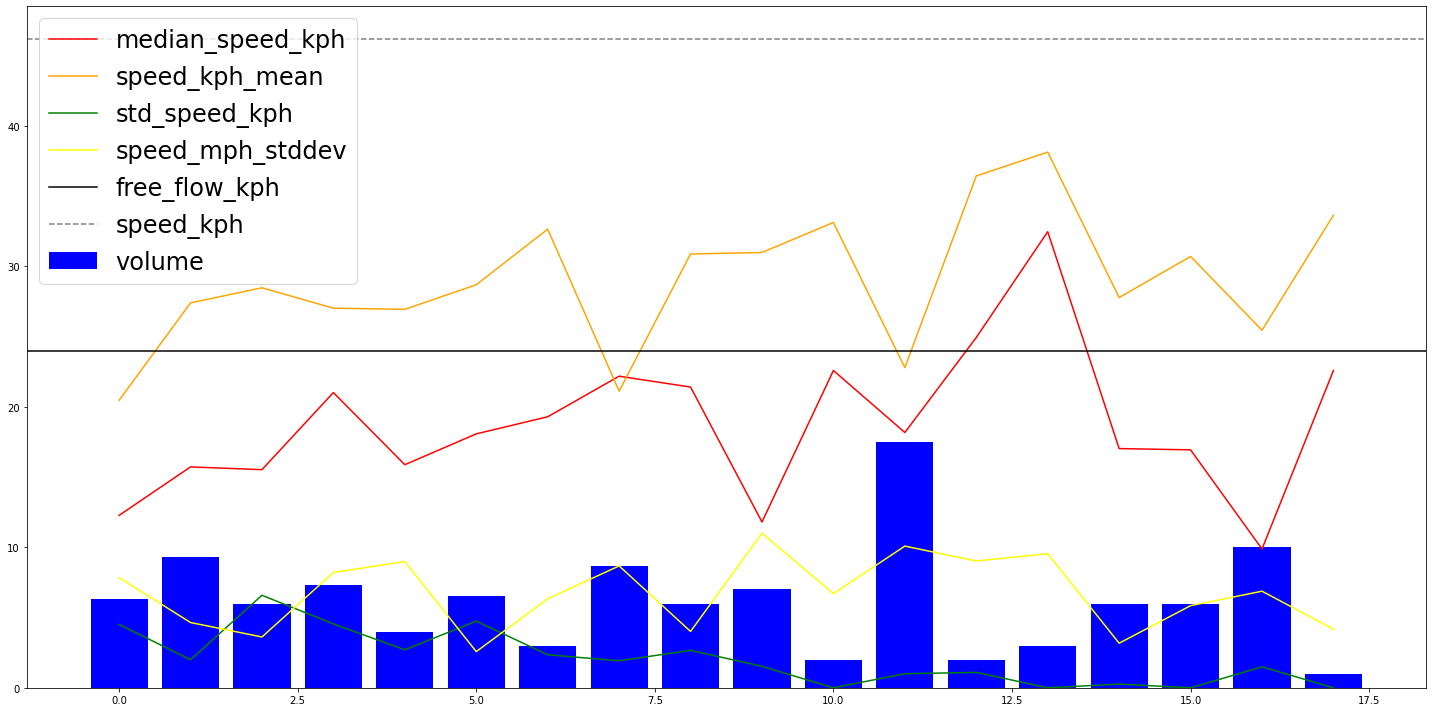

In [89]:
visualize_extreme_case(9999, extreme_edges_low)

year                                    2019.0
month                                     10.0
day                                       25.0
hour                                      16.0
speed_diff                          -16.399775
std_speed_kph                         2.294118
median_speed_kph                     12.176471
speed_kph_mean                       28.576246
free_flow_kph                        28.705882
speed_kph                                 32.2
length_meters                        58.904383
x_u                                  -0.076496
y_u                                  51.455589
x_v                                  -0.076198
y_v                                  51.456027
name                             Lordship Lane
count                                        2
u                                     21586034
v                                     33778200
gkey                21586034_33778200_38697242
highway                                primary
Name: 8841, d

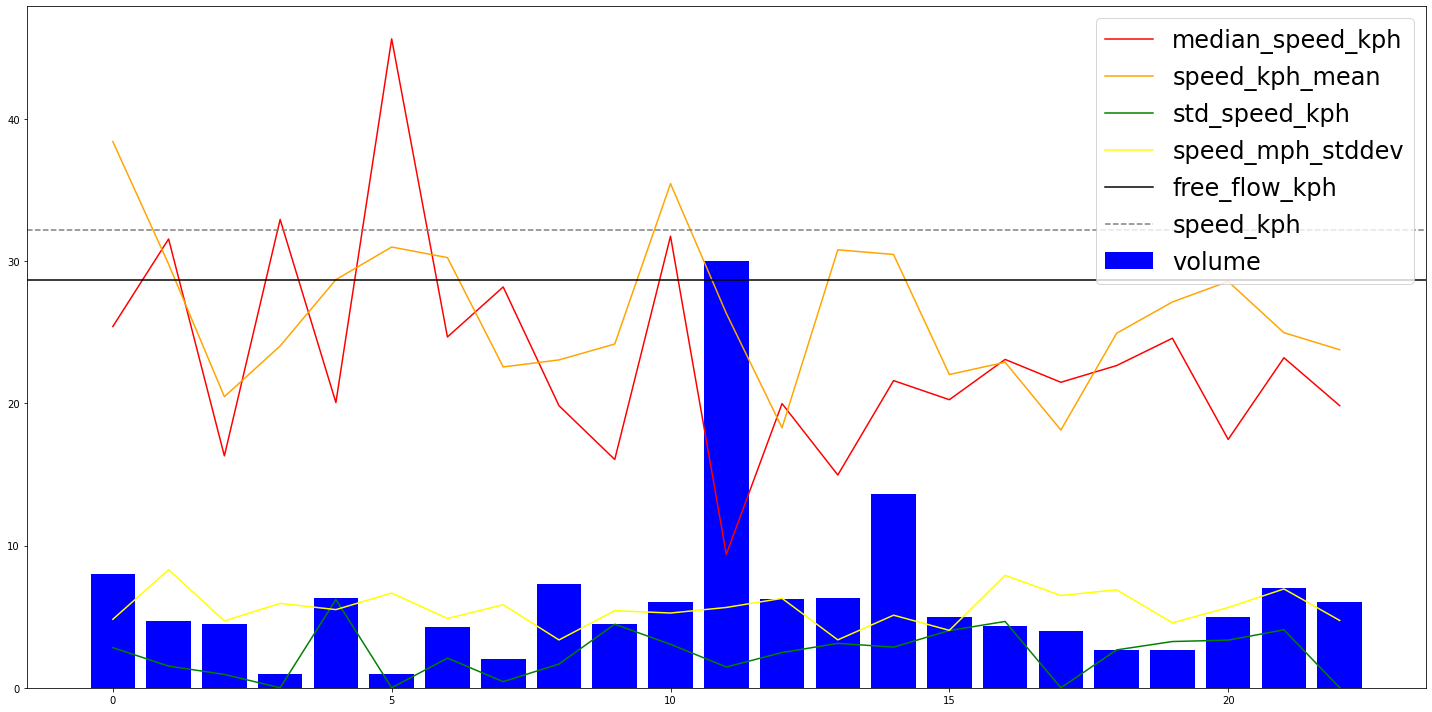

In [90]:
visualize_extreme_case(12000, extreme_edges_low)

In [91]:
extreme_edges_low.groupby("highway").count()

year  month    day   hour  speed_diff  std_speed_kph  \
highway                                                                 
living_street      23     23     23     23          23             23   
primary         11035  11035  11035  11035       11035          11035   
primary_link       89     89     89     89          89             89   
residential      2561   2561   2561   2561        2561           2561   
secondary        3322   3322   3322   3322        3322           3322   
secondary_link     25     25     25     25          25             25   
service             5      5      5      5           5              5   
tertiary         4081   4081   4081   4081        4081           4081   
tertiary_link      21     21     21     21          21             21   
trunk            3728   3728   3728   3728        3728           3728   
trunk_link        115    115    115    115         115            115   
unclassified     1172   1172   1172   1172        1172           1172   

                median_speed_kph  speed_kph_mean  free_flow_kph  speed_kph  \
highway                                                                      
living_street                 23              23             23         23   
primary                    11035           11035          11035      11035   
primary_link                  89              89             89         89   
residential                 2561            2561           2561       2561   
secondary                   3322            3322           3322       3322   
secondary_link                25              25             25         25   
service                        5               5              5          5   
tertiary                    4081            4081           4081       4081   
tertiary_link                 21              21             21         21   
trunk                       3728            3728           3728       3728   
trunk_link                   115             115            115        115   
unclassified                1172            1172           1172       1172   

                length_meters    x_u    y_u    x_v    y_v   name  count  \
highway                                                                   
living_street              23     23     23     23     23     23     23   
primary                 11035  11035  11035  11035  11035  11035  11035   
primary_link               89     89     89     89     89     89     89   
residential              2561   2561   2561   2561   2561   2561   2561   
secondary                3322   3322   3322   3322   3322   3322   3322   
secondary_link             25     25     25     25     25     25     25   
service                     5      5      5      5      5      5      5   
tertiary                 4081   4081   4081   4081   4081   4081   4081   
tertiary_link              21     21     21     21     21     21     21   
trunk                    3728   3728   3728   3728   3728   3728   3728   
trunk_link                115    115    115    115    115    115    115   
unclassified             1172   1172   1172   1172   1172   1172   1172   

                    u      v   gkey  
highway                              
living_street      23     23     23  
primary         11035  11035  11035  
primary_link       89     89     89  
residential      2561   2561   2561  
secondary        3322   3322   3322  
secondary_link     25     25     25  
service             5      5      5  
tertiary         4081   4081   4081  
tertiary_link      21     21     21  
trunk            3728   3728   3728  
trunk_link        115    115    115  
unclassified     1172   1172   1172

In [92]:
extreme_edges_low.groupby("highway").median()

year  month        day       hour  speed_diff  \
highway                                                           
living_street   2019.0   10.0  23.714286  13.000000  -14.158496   
primary         2019.0   10.0  24.200000  13.000000  -16.181563   
primary_link    2019.0   10.0  24.000000  13.500000  -15.250824   
residential     2019.0   10.0  24.000000  12.800000  -15.179051   
secondary       2019.0   10.0  24.000000  12.800000  -15.993208   
secondary_link  2019.0   10.0  24.000000  12.500000  -16.170175   
service         2019.0   10.0  23.291667  12.368421  -15.210651   
tertiary        2019.0   10.0  24.000000  12.750000  -16.049240   
tertiary_link   2019.0   10.0  24.500000  14.666667  -15.439546   
trunk           2019.0   10.0  24.222222  13.000000  -16.034636   
trunk_link      2019.0   10.0  24.200000  13.666667  -16.737855   
unclassified    2019.0   10.0  23.730303  12.500000  -14.797983   

                std_speed_kph  median_speed_kph  speed_kph_mean  \
highway                                                           
living_street        3.443355         11.025531       23.499261   
primary              2.681373         10.781513       27.195700   
primary_link         2.023693         11.271732       26.503416   
residential          2.407217         10.088235       25.473438   
secondary            2.470588         10.683551       26.979834   
secondary_link       1.529412         12.257353       27.762724   
service              0.154902         10.492157       26.041662   
tertiary             2.490196         10.588235       26.789074   
tertiary_link        3.748366         11.264706       27.235446   
trunk                2.923475         11.292048       27.470361   
trunk_link           2.555556         11.311463       27.645243   
unclassified         2.160436          9.592488       24.356456   

                free_flow_kph  speed_kph  length_meters       x_u        y_u  \
highway                                                                        
living_street       26.352941       32.2      39.966399 -0.174105  51.498615   
primary             29.647059       48.3      39.256230 -0.126310  51.511351   
primary_link        28.705882       48.3      26.562954 -0.102443  51.511631   
residential         25.882353       32.2      60.989847 -0.152651  51.502592   
secondary           28.705882       32.2      43.594467 -0.145924  51.513726   
secondary_link      24.000000       48.1      29.420497 -0.135074  51.527702   
service             22.117647       32.2      27.965149 -0.126679  51.515670   
tertiary            27.764706       32.2      48.801236 -0.120801  51.519261   
tertiary_link       50.039216       48.3      45.638910 -0.064443  51.523991   
trunk               31.764706       48.3      36.898458 -0.121132  51.486285   
trunk_link          38.588235       48.3      33.671322 -0.137253  51.511715   
unclassified        24.000000       32.2      49.722990 -0.119662  51.519178   

                     x_v        y_v  count             u             v  
highway                                                                 
living_street  -0.174105  51.498615    9.0  3.879402e+08  3.879397e+08  
primary        -0.126257  51.511437    4.0  3.064626e+08  3.435881e+08  
primary_link   -0.102217  51.511816    4.0  1.617532e+09  1.794637e+09  
residential    -0.152534  51.502622    3.0  7.097044e+07  1.857145e+08  
secondary      -0.145912  51.513805    3.0  3.116148e+08  3.519849e+08  
secondary_link -0.135074  51.527628    3.0  1.937820e+09  1.697714e+09  
service        -0.126535  51.515876   24.0  1.937730e+09  3.304492e+07  
tertiary       -0.120709  51.519330    3.0  2.696638e+08  3.014799e+08  
tertiary_link  -0.064531  51.523651    3.0  2.429309e+08  1.203361e+09  
trunk          -0.121132  51.486343    4.0  4.492042e+08  5.120432e+08  
trunk_link     -0.136548  51.511728    3.0  1.485256e+09  1.363660e+09  
unclassified   -0.119866  51.519221    4.0  3.254255e+08  4.718280e+08

In [93]:
extreme_edges_low.groupby("highway").max()

year  month       day       hour  speed_diff  std_speed_kph  \
highway                                                                         
living_street   2019.0   10.0  26.00000  13.916667  -10.848278       6.837468   
primary         2019.0   10.0  27.00000  17.000000  -10.070841      27.600666   
primary_link    2019.0   10.0  27.00000  17.000000  -10.118540      18.838698   
residential     2019.0   10.0  27.00000  17.000000  -10.010268      13.294118   
secondary       2019.0   10.0  27.00000  17.000000  -10.179159      18.878507   
secondary_link  2019.0   10.0  25.25000  16.500000  -11.204813       8.634552   
service         2019.0   10.0  23.46875  13.400000  -13.012888       4.558773   
tertiary        2019.0   10.0  27.00000  17.000000  -10.109287      14.288898   
tertiary_link   2019.0   10.0  27.00000  17.000000  -11.955923       7.454896   
trunk           2019.0   10.0  27.00000  17.000000  -10.114093      18.827360   
trunk_link      2019.0   10.0  27.00000  17.000000  -10.388649      24.177670   
unclassified    2019.0   10.0  27.00000  17.000000  -10.092184      18.063916   

                median_speed_kph  speed_kph_mean  free_flow_kph  speed_kph  \
highway                                                                      
living_street          13.405637       30.143341      28.235294       48.3   
primary                14.965686       59.400471      78.666667       96.6   
primary_link           14.166667       48.816110      78.588235       80.5   
residential            14.911765       67.525492      76.705882       48.3   
secondary              14.882353       47.747508      79.058824       64.4   
secondary_link         13.647059       33.141139      80.941176       80.5   
service                10.866558       48.110254      32.470588       33.6   
tertiary               14.882353       52.291480      86.117647       80.5   
tertiary_link          14.607843       63.760441      78.588235       80.5   
trunk                  14.779412       68.128593      81.882353       96.6   
trunk_link             14.588235       53.553317      78.588235       80.5   
unclassified           14.705882       56.797632      78.117647       80.5   

                length_meters       x_u        y_u       x_v        y_v  \
highway                                                                   
living_street      132.420979 -0.084036  51.524666 -0.084303  51.524666   
primary            987.907499  0.074221  51.692209  0.067389  51.692373   
primary_link       336.284398  0.066229  51.602527  0.066013  51.602509   
residential        647.663062  0.052865  51.621001  0.052779  51.621253   
secondary          724.887900  0.064725  51.691241  0.064790  51.691846   
secondary_link     282.465063 -0.008815  51.606879 -0.006344  51.606934   
service             30.761112 -0.126407  51.516121 -0.126345  51.516286   
tertiary           935.504468  0.066572  51.664842  0.067189  51.663962   
tertiary_link      536.112598  0.032436  51.616158  0.032571  51.616290   
trunk              579.736122  0.066624  51.680510  0.066879  51.680064   
trunk_link         449.502537  0.059039  51.616178  0.059123  51.616178   
unclassified       910.192198  0.066321  51.614019  0.066438  51.614019   

                            name  count           u           v  \
highway                                                           
living_street     Leonard Street     23  6280192965  6280192965   
primary                 York Way     69  6552047209  6554185527   
primary_link       Woolwich Road     69  6530619881  6530619874   
residential         Young Street     57  6575658505  6575658507   
secondary            Wrythe Lane     63  6565099578  6565107318   
secondary_link         York Road     16  5374174120  5374174223   
service         Wandsworth Road      38  5630766895  5630766895   
tertiary             Yester Road     66  6577730921  6577730921   
tertiary_link           West Way     15  4060361447  4927602968   
tr

In [94]:
extreme_edges_low[extreme_edges_low["length_meters"] > 150]

year  month   day       hour  speed_diff  std_speed_kph  \
4203   2019.0   10.0  26.0  11.333333  -59.466194      16.442566   
16004  2019.0   10.0  27.0  15.000000  -51.183644      10.867195   
8380   2019.0   10.0  26.0   9.666667  -50.422144      10.437480   
20205  2019.0   10.0  27.0  15.000000  -48.349960      13.828612   
40890  2019.0   10.0  27.0  15.500000  -48.261743       6.621994   
...       ...    ...   ...        ...         ...            ...   
40472  2019.0   10.0  24.5  16.500000  -10.434391       4.440011   
23081  2019.0   10.0  23.0  14.500000  -10.348883       9.294118   
3455   2019.0   10.0  23.5  13.000000  -10.323234       4.764549   
36739  2019.0   10.0  24.0  16.000000  -10.150995       5.537865   
15695  2019.0   10.0  26.0  15.000000  -10.077709       1.294118   

       median_speed_kph  speed_kph_mean  free_flow_kph  speed_kph  ...  \
4203           7.930283       67.396477      72.941176       80.5  ...   
16004          7.882353       59.065997      58.823529       48.3  ...   
8380          12.666667       63.088810      62.588235       64.4  ...   
20205          7.591503       55.941463      46.588235       48.3  ...   
40890          7.411765       55.673508      54.588235       64.4  ...   
...                 ...             ...            ...        ...  ...   
40472         12.627451       23.061842      38.823529       48.3  ...   
23081         12.588235       22.937118      24.941176       32.2  ...   
3455          12.421569       22.744802      30.588235       48.3  ...   
36739         13.117647       23.268642      30.470588       32.2  ...   
15695         12.588235       22.665945      24.000000       36.3  ...   

            x_u        y_u       x_v        y_v                       name  \
4203   0.050827  51.455107  0.053296  51.455369  Rochester Way Relief Road   
16004 -0.235670  51.573757 -0.233551  51.572036               Edgware Road   
8380  -0.104700  51.368309 -0.103207  51.369414        The Croydon Flyover   
20205 -0.233551  51.572036 -0.230477  51.569591          Edgware Road West   
40890 -0.028890  51.652484 -0.029947  51.648989            Mollison Avenue   
...         ...        ...       ...        ...                        ...   
40472 -0.106941  51.625549 -0.105470  51.624677                Bourne Hill   
23081 -0.106587  51.541410 -0.108066  51.541211               Lofting Road   
3455  -0.183047  51.490760 -0.181068  51.488547            Drayton Gardens   
36739 -0.191564  51.472482 -0.190091  51.471774             Hazlebury Road   
15695 -0.160815  51.488808 -0.161999  51.488057      St. Leonard's Terrace   

      count           u          v                            gkey  \
4203      3      432734     432731          432734_432731_22970524   
16004     2    42324714  242703635     42324714_242703635_22633180   
8380      3    21381847   78326960      21381847_78326960_10423847   
20205     2   242703635     525071       242703635_525071_22633385   
40890     2  5460946893  283333835  5460946893_283333835_567247990   
...     ...         ...        ...                             ...   
40472     2  5277517867     201187      5277517867_201187_23245270   
23081     2   332673180  332673185     332673180_332673185_2430956   
3455      2      276554   18127040         276554_18127040_4422803   
36739     2  3451067745   13565582     3451067745_13565582_4422135   
15695     2    37879363   37877761       37879363_37877761_5319173   

            highway  
4203          trunk  
16004       primary  
8380          trunk  
20205       primary  
40890       primary  
...             ...  
40472       primary  
23081  unclassified  
3455       tertiary  
36739   residential  
15695   residential  

[1617 rows x 21 columns]